# **AA1 Project** 

## Modeling delays in the air

In order to predict whether a flight is likely to be delayed or not, create a ML model that will make predictions with that aim. 

First of all. Let's observe our data set and some first insights. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter

In [2]:
airports = pd.read_csv('airports.csv')

In [3]:
flights = pd.read_csv('flights.csv')
flights = flights.sample(frac=0.0025, random_state=42)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_1437/2102207835.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


As we can se with the `describe` method, we can observe the range where each feature takes values at more or less. It is also interesting to observe the histograms of the different columns to see how each feature is distributed more or less, to get an intuition of our data. 

In [4]:
flights.describe()
airports.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


array([[<AxesSubplot: title={'center': 'YEAR'}>,
        <AxesSubplot: title={'center': 'MONTH'}>,
        <AxesSubplot: title={'center': 'DAY'}>,
        <AxesSubplot: title={'center': 'DAY_OF_WEEK'}>,
        <AxesSubplot: title={'center': 'FLIGHT_NUMBER'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_DEPARTURE'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_TIME'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>,
        <AxesSubplot: title={'center': 'WHEELS_OFF'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'ELAPSED_TIME'}>,
        <AxesSubplot: title={'center': 'AIR_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'WHEELS_ON'}>],
       [<AxesSubplot: title={'center': 'TAXI_IN'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_ARRIVAL'}>,
        <AxesSubplot: title={'center': 'ARRIVAL_TIME'}>

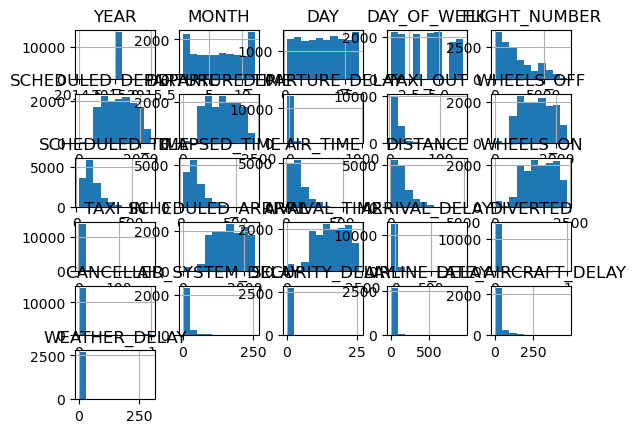

In [5]:
flights.hist()

Based on the results of the histograms, we can appreciate that some of the variables in our dataset present variables where the data appears to be quite concentrated and this could be explained by the presence of large outliers. Some other variables seem to be more uniformally distributed. However, the nature of the distribution that describes the data in our variables shouldn't worry ourselve to much right now as many data processment will be done (including gaussianization of the continuos variables and hot encoding of the categorical ones) before trainging and testing a model.

## 1. Data cleaning
### Nextly we will portray the schedule that we are going to follow. 
1. Check for duplicates: Check for and remove any duplicate rows in our dataset.

2. Handle missing data: Identify any missing data and decide how to handle it. We will either remove the rows or fill in the missing data.

3. Check for inconsistent data: Check for any inconsistent or erroneous data, such as values that are out of range or inconsistent with other data in the same row.

4. Handle categorical data: If you have categorical data, decide how to handle it. One common approach is to use one-hot encoding.

5. Normalize data: Normalize the data so that the features have similar ranges. This will prevent features with large ranges from dominating the model.

6. Feature selection: Select the most relevant features for your model. You can use various techniques such as correlation analysis or principal component analysis (PCA).

7. Train-test split: Finally, split your data into training and testing sets to evaluate the performance of your machine learning model.

### 1.1 Check for duplicates
We firstly see that there are no duplicate samples with the following piece of code.


In [6]:
# Check for duplicates
duplicates = flights.duplicated()

# Print the duplicate rows
len(flights[duplicates])

0

### 1.2 Handle missing data
In this section we have a bunch of different possibilities in order to approach the problem of missing data. 
1. Remove missing data: if the quantity of missing data is not that significative, maybe it is a good option to consider removing all those samples that contain `NaN` values since the subset of samples that is going to be deleted may not be significant while training the model. 



In [7]:
# Count the number of NaN values in each column
nan_counts = flights.isna().sum()
# Print the results
print(nan_counts)

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER               34
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME           204
DEPARTURE_DELAY          204
TAXI_OUT                 217
WHEELS_OFF               217
SCHEDULED_TIME             0
ELAPSED_TIME             253
AIR_TIME                 253
DISTANCE                   0
WHEELS_ON                226
TAXI_IN                  226
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME             226
ARRIVAL_DELAY            253
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    14330
AIR_SYSTEM_DELAY       11803
SECURITY_DELAY         11803
AIRLINE_DELAY          11803
LATE_AIRCRAFT_DELAY    11803
WEATHER_DELAY          11803
dtype: int64


From the previous output we see that the last 6 features are almost useless since the majority of the samples do not have any information of those, therefore we are going to `drop`. A part from that, we also need to delete columns that regard information that is not going to be available (a posteriori information from the flight) such as information of the time elapsed during time

In [8]:
cols_of_interest = ['ARRIVAL_DELAY','MONTH', 'DAY' ,'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE']
flights = flights[cols_of_interest]

In [9]:
flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,14295.000000,14548.000000,14548.000000,14548.000000,14548.000000,14344.000000,14344.000000,14331.000000,14331.000000,14548.000000,14548.000000
mean,4.397761,6.505774,15.762373,3.890019,1495.689098,1336.571249,9.245259,16.187217,1360.064057,142.108675,823.882596
std,37.434848,3.415867,8.794217,1.977637,507.325283,497.630899,35.066599,8.955900,498.626400,75.483655,609.618878
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,3.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1110.000000,922.000000,-5.000000,11.000000,936.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1522.000000,1331.000000,-2.000000,14.000000,1345.000000,123.000000,647.000000
75%,8.000000,9.000000,23.000000,6.000000,1919.000000,1743.000000,8.000000,19.000000,1758.000000,174.000000,1066.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,965.000000,145.000000,2359.000000,680.000000,4983.000000


Once we've deleted those columns we can say that **maybe** and only **maybe** taking into account that we have more than 5M samples, deleting the other samples that contain at least one `NaN` value, may be reasonable. 

**CHECK WHETHER THIS IS REASONABLE**

In [10]:
l_bef = len(flights)
flights = flights.dropna(how='any')
l_aft = len(flights)
print(l_bef, l_aft)


14548 14295


We pass from $5819079$ to $5714008$ samples. In other words, we keep the $98.2\%$ of the samples, so it may be a good option to work with these new subset of samples that still contain a vast quantity of information.   

### 1.3 Check for inconsistent data
In order to do so, we firstly observe an overview of our data. 


In [11]:
flights.describe()



,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000
mean,4.397761,6.521791,15.751522,3.896747,1494.538370,1336.156208,9.159706,16.186079,1359.684715,142.320462,826.171319
std,37.434848,3.404917,8.782405,1.975532,507.725006,497.734898,34.840084,8.961210,498.663054,75.566948,610.236930
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,3.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1110.000000,922.000000,-5.000000,11.000000,936.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1521.000000,1331.000000,-2.000000,14.000000,1345.000000,123.000000,650.000000
75%,8.000000,9.000000,23.000000,6.000000,1917.000000,1743.000000,8.000000,19.000000,1758.000000,174.000000,1067.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,965.000000,145.000000,2359.000000,680.000000,4983.000000


And we will plot a few histograms of the variables in our dataset to get a deeper understanding of their nature. First of all we are going to implement a function that is going to allow us to plot the histogram and personalize a few parameters such as the title, labels for the axis and the options to apply logarithms to any of the axis.

In [12]:
def plot_histogram_of_column(data, title, x_title, y_title, x_log, y_log):
    # Assign default title if none is provided
    if not title:
        title = "Histogram"

    # Assign default title to x axis if none is provided
    if not x_title:
        x_title = "Value"
    
    # Assing default title to y axis if none is provided
    if not y_title:
        y_title = "Count"
    
    # Apply logarithm to x axis if required
    if x_log:
        # Set up histogram with logarithmic x-axis
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data, bins=10**np.linspace(np.log10(0.1), np.log10(data.max()), 50))

        # Set x-axis to logarithmic scale
        ax.set_xscale('log')

        # Add "log" to x axis title
        x_title = "Log " + x_title
    else:
        # Create plot with histogram of DAY column
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data)


    # Apply logarithm to y-axis if required
    if y_log:
        ax.set_yscale('log')

        # Add "log" to y axis title
        y_title = "Log " + y_title
    
    # Add labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Show plot
    plt.show()

Now that we have created a function that allows us to easily plot any column from the dataset that we are interested in, we will start by studying the nature of the columns that refer to delays on the flights

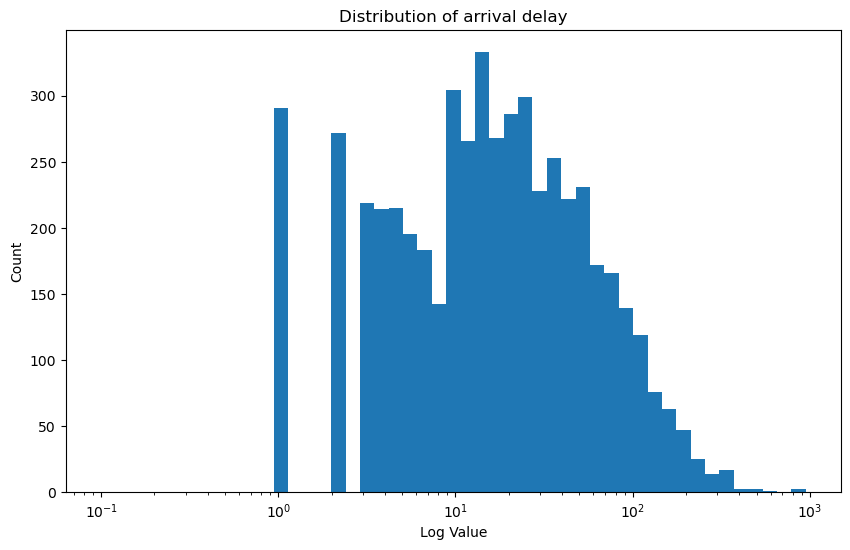

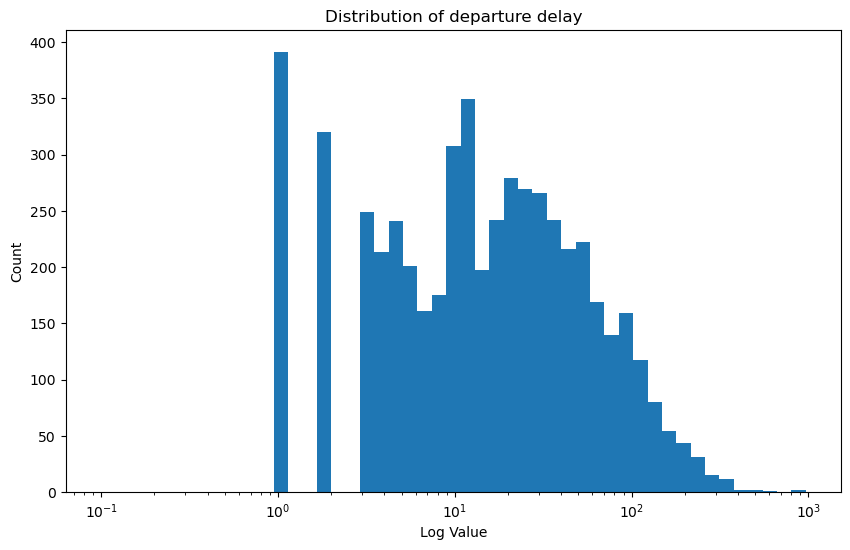

In [13]:
# Plot of the arrival_delay column
plot_histogram_of_column(flights["ARRIVAL_DELAY"], "Distribution of arrival delay", None, None, True, False)

# Histogram of DEPARTURE_DELAY column
plot_histogram_of_column(flights["DEPARTURE_DELAY"], "Distribution of departure delay", None, None, True, False)

It can be seen that both histograms share a similar shape, which means that these two variables are strongly correlated. However, we expected to get this result since those flights that suffer departure with any form of delay are extremely likely to also arrive with a similar delay.

Another interesting result extracted from the data is that there are quite a lot of flights that depart before their scheduled departure time. Moreover, if we compare closely both histograms, we will notice that the amount of flights that arrive before their arrival time is smaller than the number of flights that departure ahead of their departure time.

Next we are going to analyse how the variables containing data related with the date of the flight are distributed.

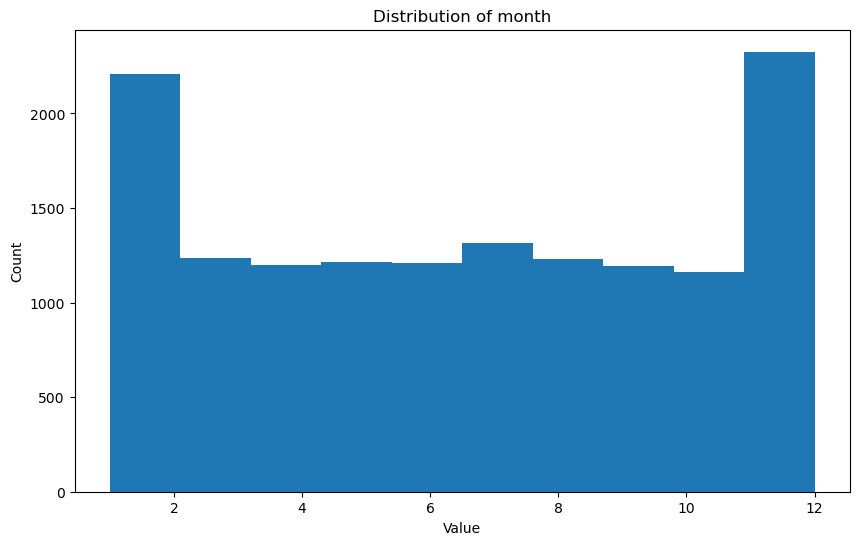

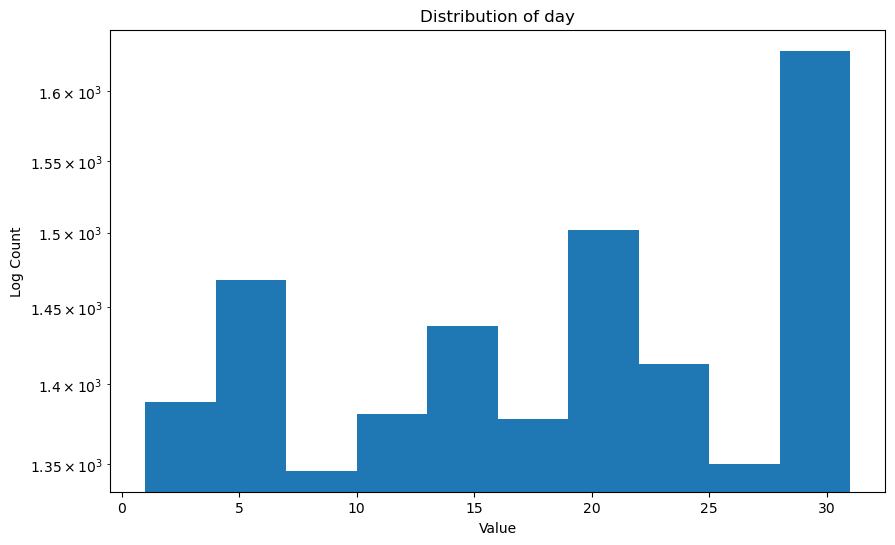

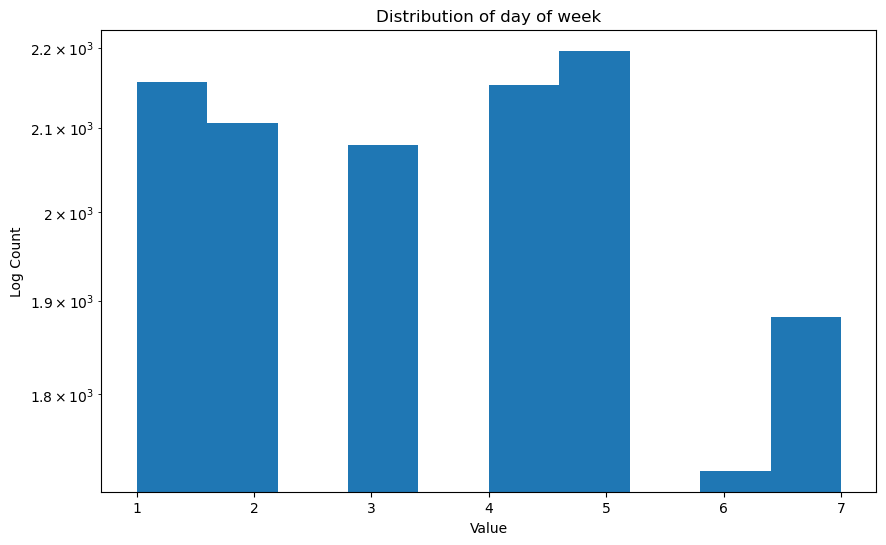

In [14]:
plot_histogram_of_column(flights["MONTH"], "Distribution of month", None, None, False, False)

# Create plot with histogram of DAY column
plot_histogram_of_column(flights["DAY"], "Distribution of day", None, None, False, True)

# Histogram of DAY_OF_WEEK colum
plot_histogram_of_column(flights["DAY_OF_WEEK"], "Distribution of day of week", None, None, False, True)



And, finally, we'll plot some other columns that could be interesting to analyse.

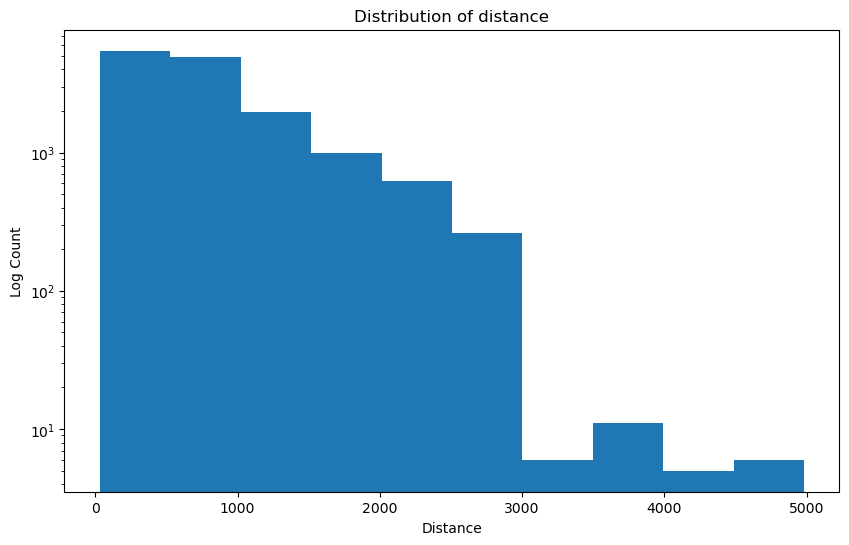

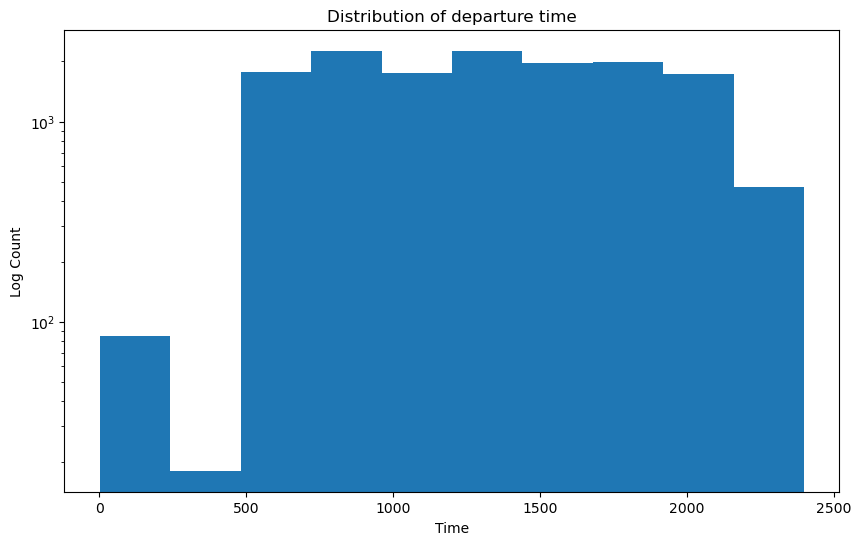

In [15]:
plot_histogram_of_column(flights["DISTANCE"], "Distribution of distance", "Distance", None, False, True)

plot_histogram_of_column(flights["DEPARTURE_TIME"], "Distribution of departure time", "Time", None, False, True)

Looking at the distance plot, we observe that the distance of the vast majority of flights range between a few hundred and a three thousand miles. The longest flights in the dataset are around 5000 miles. 

On the other hand, looking at the distribution of the departure time variabel, we see that fligh departure are almos uniformly distributed from 6 am to 8 pm. From 9 pm to 5 am, a much smaller number of departure take place.

In [16]:
print(flights["DESTINATION_AIRPORT"].unique())

['DTW' 'SEA' 'DAL' 'HNL' 'ATL' 'TPA' 'PHX' 'LAX' 11292 'BWI' 'SJU' 'SMF'
 'BNA' 'CLT' 'CAE' 'MSP' 'DFW' 'SAN' 'OGG' 'OAK' 14107 'DCA' 'BOS' 'HRL'
 'MCI' 'SNA' 'ORD' 'MIA' 'RNO' 12451 'SFO' 'SAT' 'IAH' 'SLC' 'LAS' 'DEN'
 'PIT' 'ACV' 'DRO' 'GSP' 'RSW' 'ITO' 12266 'LSE' 'OKC' 'DAY' 'EWR' 10299
 'PHL' 'HOU' 11298 'MFE' 'FLL' 'MSY' 'IND' 'BZN' 'PSP' 'ASE' 'MEM' 'RDU'
 'SBA' 15016 'SJC' 11066 'JAC' 'MCO' 'ROC' 11697 'BOI' 'CLE' 13830 10257
 14908 'SDF' 12278 'MKE' 'JFK' 12889 10397 'RDM' 13851 'BRW' 'ALB' 'OMA'
 'CRP' 'RIC' 'DHN' 11618 'BUR' 'CVG' 'MDW' 14893 'JAX' 13485 'ABQ' 12402
 'CMH' 12264 10721 'PVD' 11433 'KTN' 10154 'LGA' 'PDX' 'LRD' 'SYR' 'PBI'
 'ANC' 'BUF' 'RST' 'TUL' 'TUS' 'STL' 'TLH' 'BDL' 'AUS' 'MSN' 11278 13204
 14771 'CHS' '13232' 'DSM' '12478' 14869 'AMA' 'LGB' 'GRR' 'IAD' 10874
 'ONT' 'LIH' 'PIB' 15370 10980 13303 'GSO' 'MYR' 12478 11057 'BIS' 13930
 'CDV' 14679 10713 'MOB' 14576 'KOA' 'TRI' 'CHO' 14843 'LEX' 11447 'MGM'
 15919 14057 'ELP' 'IDA' 'MVY' 'EWN' 13487 10140 'COS

In [17]:
flights.loc[flights['WHEELS_OFF'] == 2400, 'WHEELS_OFF'] = 2359
flights.loc[flights['DEPARTURE_TIME'] == 2400, 'DEPARTURE_TIME'] = 2359



flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000,14295.000000
mean,4.397761,6.521791,15.751522,3.896747,1494.538370,1336.153340,9.159706,16.186079,1359.684715,142.320462,826.171319
std,37.434848,3.404917,8.782405,1.975532,507.725006,497.728885,34.840084,8.961210,498.663054,75.566948,610.236930
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,3.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1110.000000,922.000000,-5.000000,11.000000,936.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1521.000000,1331.000000,-2.000000,14.000000,1345.000000,123.000000,650.000000
75%,8.000000,9.000000,23.000000,6.000000,1917.000000,1743.000000,8.000000,19.000000,1758.000000,174.000000,1067.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2359.000000,965.000000,145.000000,2359.000000,680.000000,4983.000000


As we can infer from the output of the `decribe()` method, there are no values that are out of range or are non-sense in comparison with other values of the same column. 

In [18]:
# Delete all of the rows that contain integer values
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: isinstance(x, int))]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: isinstance(x, int))]


In [19]:
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: str(x).isnumeric())]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: str(x).isnumeric())]

### 1.4 Handle categorical data


We are going to start by looking at our columns to determine what type of data each one of them contains.


In [20]:
#Check nature of the columns 
for col in flights.columns:
  print(col, flights[col].dtype)

ARRIVAL_DELAY float64
MONTH int64
DAY int64
DAY_OF_WEEK int64
AIRLINE object
ORIGIN_AIRPORT object
DESTINATION_AIRPORT object
SCHEDULED_ARRIVAL int64
DEPARTURE_TIME float64
DEPARTURE_DELAY float64
TAXI_OUT float64
WHEELS_OFF float64
SCHEDULED_TIME float64
DISTANCE int64


Now that we have an idea of the nature of each column we must determine which columns we are going to modify. Those columns are going to be the ones containing categorical variables. We are going to modify:
- Month
- Arrival_delay
- Day
- Day_of_week
- Origin_airport
- Destination_airport

The next thing we want to do after observing the types of every feature is to transform some variables to categorical

#### Month column

The transformation we have chosen for the MONTH column is grouping the month by quarters. This will allow us to reduce the number of categories from 12 to 3. 

Additionally, when dividing the year in quarters we get a partition that closely matches the different travel seasons. Summer season matches almost perfectly with the second quarter while the first and third quarter match with winter season.

In [21]:
# MONTH treatment: group months in quarters
flights['Q_YEAR'] = flights['MONTH'].apply(lambda x: (x-1)//4 + 1)

#### Arrival_delay column

Another column which's data we need to process is the ARRIVAL_DELAY column. This column is the one we want to predict and the aim of our model is to be able to predict if a flight will arrive to its destination with some type of delay. Therefore, we want to convert this column into a column with binary values.

We will create a new column in our dataset (i.e. DELAYED) which will have a 1 if the flight is delayed and 0 otherwise.

In [22]:
# DELAY TREATMENT
flights['DELAYED'] = flights['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

#### Day column

The DAY column has values that range from 1 to 31, which it's unfeasible to work with. We have decided to divide the month in two fortnights and classify each day with the value of the fortnight they belong to. 
- From days 1 - 15 they will belong to the first fortnight. They will have a value of 1.
- From days 15 - 31 they will belong to the second fortnight. The will have a value of 2.

In [23]:
# DAY treatment 

flights['FORTNIGHT'] = pd.cut(flights['DAY'], bins=[0, 15, 31], labels=[1, 2], include_lowest=True)


We believe that this is an appropiate transformation because, usually, people earn they salaries at the end of the month. Therefore, people will have more money available during the first fortnight and this could mean that the number of passengers increase causing to be more flights during the first fortnight. 


#### Day_of_week column

The same arguments we used for the DAY column apply to DAY_OF_WEEK. The values in this column range from 1 (i.e.: Monday) to 7 (i.e.: Sunday). Instead of working with each of this values, we are going to separate them into working days and weekends.

In [24]:
# DAY_OF_WEEK 1 is in-week days, 2 is weekend

flights['WEEK_INFO'] = pd.cut(flights['DAY_OF_WEEK'], bins=[1, 5, 7], labels=[1, 2], include_lowest=True)


#### Airline column

We are now going to treat the AIRLINES column. Originally, our dataframe had around 15 different airlines and we considered that it was going to be unfeasible to work with all of them. Therefore, we have decided to divide them intro three major groups:
- Major airlines
- Low cost airlines
- Regional airlines

We believe that this is a valid division because the nature of the airline could possibly affect the amount of delayed flights they have. 

In [25]:
# AIRLINE

# Define the airlines categories
major_airlines = ['DL', 'AA', 'UA', 'US', 'AS']
low_cost_airlines = ['WN', 'NK', 'F9', 'B6', 'VX']
regional_airlines = ['EV', 'OO', 'MQ', 'HA']

# create a new column with the airline category
flights['AC'] = 'Other'
flights.loc[flights['AIRLINE'].isin(major_airlines), 'AC'] = 'Major'
flights.loc[flights['AIRLINE'].isin(low_cost_airlines), 'AC'] = 'Low-Cost'
flights.loc[flights['AIRLINE'].isin(regional_airlines), 'AC'] = 'Regional'

#### Origin_airport column

In the original dataset there are over 300 different airports. Although it would be great to be able to keep all of them as individual categories, we have also considered it unfeasible. So, in order to reduce the number of categories, we are going to divide the USA territory in four quadrants:
- Upper left
- Upper right
- Bottom right
- Bottom left

However, before being able to classify the airports as we just mentioned, we first need to get its coordinates. This can be achieved by extractinc the necessary data (i.e. longitude and latitude) from the *airports* dataset

In [26]:
# Change the index of the dataset to the IATA_CODE (code that identifies each airport)
airports = airports.set_index('IATA_CODE')

In [27]:
# Add LONGITUDE_O column to each row in flights with the longitude of the origin airport
flights['LONGITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])

# Add LATITUDE_O column to each row in flights with the latitude of the origin airport
flights['LATITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])

However, we have detected that some rows have a *NaN* value in either their longitude or latitude. Since this happens rarely, we can delete those columns without loosing to many rows. 

In [28]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_O"].isna() == False
count_false = sum(counter)
print(count_false/len(flights["LONGITUDE_O"]))
flights = flights.dropna(how='any')


0.999086410354016


Once we have removed al conflictive rows, we can proceed with the classification of the airports by its location.

In [29]:
# Create empty column with airport location (i.e.: GR_O)
flights['GR_O'] = ''

# Classify the airports
# Upper right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_RIGHT'

# Upper left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_LEFT'

# Bottom right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_RIGHT'

# Bottom left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_LEFT'


Lastly, we check that all airports have been given a location and that there are no empty quadrants, which would indicate that the classification is not correctly implemented.

In [30]:
flights["GR_O"].unique()

array(['UPPER_RIGHT', 'BOTTOM_LEFT', 'UPPER_LEFT', 'BOTTOM_RIGHT'],
      dtype=object)

We observe a huge amount of features which may overfit the model in case of using them all. Therefore we will try to choose an optimal subset of explanatory variables that are going to be able to give our model the enough information in order to do good predictions. 

**Observation: We cannot follow like this since we need to consider some categorical variables. REMEMBER to one_shot_encode them before going on**

#### Destination_airport column

We are going to apply the same transformations we just applied for the destination airport column. We first add the coordinates of the airports.

In [31]:
flights['LONGITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])
flights['LATITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])



We remove all rows with NaN values.

In [32]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_D"].isna() == False
count_false = sum(counter)
print(count_false)
print(len(flights["LONGITUDE_D"]))

flights = flights.dropna(how='any')

13113
13123


And classify the destination airports based on their coordinates.

In [33]:
flights['GR_D'] = ''
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_LEFT'

In [34]:
flights["GR_D"].unique()

array(['UPPER_RIGHT', 'UPPER_LEFT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'],
      dtype=object)

#### Plot of the airports classification

In order to test our airports classification, we will plot them over a USA map and assing a color to each quarter.

In [35]:
# import gmplot

# # Initialize the map with the first airport as the center point
# gmap = gmplot.GoogleMapPlotter(flights.iloc[0]['LATITUDE_O'], flights.iloc[0]['LONGITUDE_O'], zoom=3)

# # Define the color mapping for different values of GR_D
# color_map = {
#     'UPPER_RIGHT': 'red',
#     'UPPER_LEFT': 'green',
#     'BOTTOM_RIGHT': 'blue',
#     'BOTTOM_LEFT': 'purple'
# }

# # Plot each airport with its corresponding color
# for i, row in flights.iterrows():
#     color = color_map.get(row['GR_D'], 'gray')
#     gmap.marker(row['LATITUDE_O'], row['LONGITUDE_O'], color=color)

# # Draw the map and save it to an HTML file
# gmap.draw('airports_map.html')


#### Classify scheduled_time and departure_time

The original dataset has a few columns with values ranging from 0000 to 2359. This values are found in columns scheduled_time and departure_time and they represent an hour and minutes. The format is hhmm (i.e.: 1915 is 19:15).

Once again, having 2359 categories is unfeasible. The solution we have come up with is dividing the day between daytime and nightime.

In [36]:

# Define a function to classify the time segment based on the input time
def classify_time(time):
    sunrise = 600.0   # Define the time of sunrise as 6:00 am (in decimal format)
    sunset = 1800.0   # Define the time of sunset as 6:00 pm (in decimal format)
    
    if time >= sunrise and time < sunset:
        return 'Daytime'
    else:
        return 'Nighttime'
    

After having defined the function that will allow us to apply the classification, we apply it to the data.


In [37]:
# Change formatting of SCHEDULED_ARRIVAL and DEPARTURE_TIME
flights['ArrivalDayNight'] = flights['SCHEDULED_ARRIVAL'].apply(classify_time)
flights['DepartureDayNight'] = flights['DEPARTURE_TIME'].apply(classify_time)

#### Remove unwanted columns

After dealing and processing with all categorical data, we are left with a few unwanted columns, those ones we have used to create new columns. We will remove them.

In [38]:
flights.describe()
flights.columns

Index(['ARRIVAL_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'DELAYED', 'FORTNIGHT',
       'WEEK_INFO', 'AC', 'LONGITUDE_O', 'LATITUDE_O', 'GR_O', 'LONGITUDE_D',
       'LATITUDE_D', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

In [39]:
flights = flights[['DELAYED','DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']]

In [40]:
flights.columns

Index(['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC',
       'GR_O', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

## Data visualization

### IMPORTANT
In order to do the process correctly, normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance. In our case, That is what we are going to observe right now. 

In [41]:
from sklearn.model_selection import train_test_split

# Define X as the features (input variables)
X = flights.drop("DELAYED", axis=1)  # Replace "target_variable_column" with the actual name of the target column

# Define y as the target variable
y = flights["DELAYED"]  # Replace "target_variable_column" with the actual name of the target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'Q_YEAR'}>]], dtype=object)

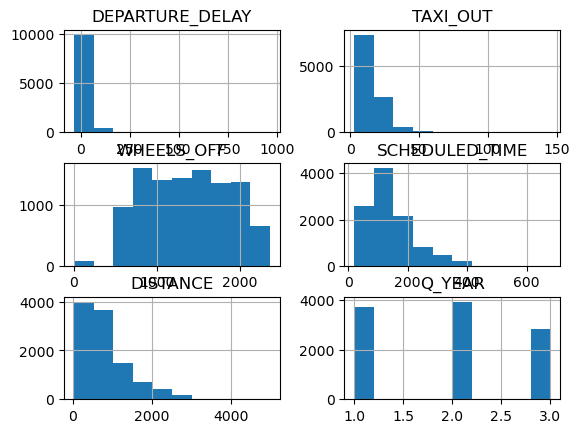

In [42]:
X_train.hist()

And we observe that the distribution of the features are the same than that of the whole dataset. 

Once we have processed all our data, it migh be interesting to, once again, visualize the distribution from some of the new columns we have added to the dataset and study if we can extract any knowledge from them.

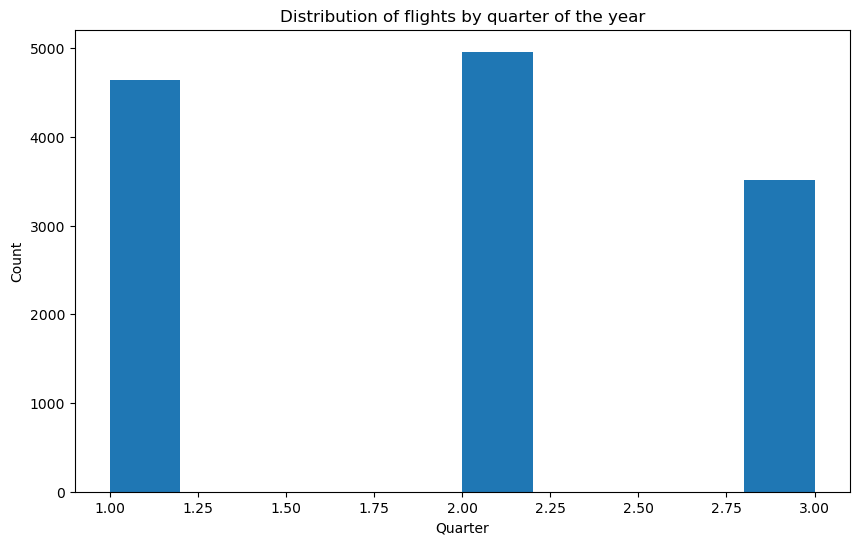

In [43]:
plot_histogram_of_column(flights["Q_YEAR"], "Distribution of flights by quarter of the year", "Quarter", None, False, False)

While the difference between the three quarters it is not huge, it is clear that, as we expected, the second quarter (i.e.: May to August) is the one with the greater amount of flights as it matches with the summer season.

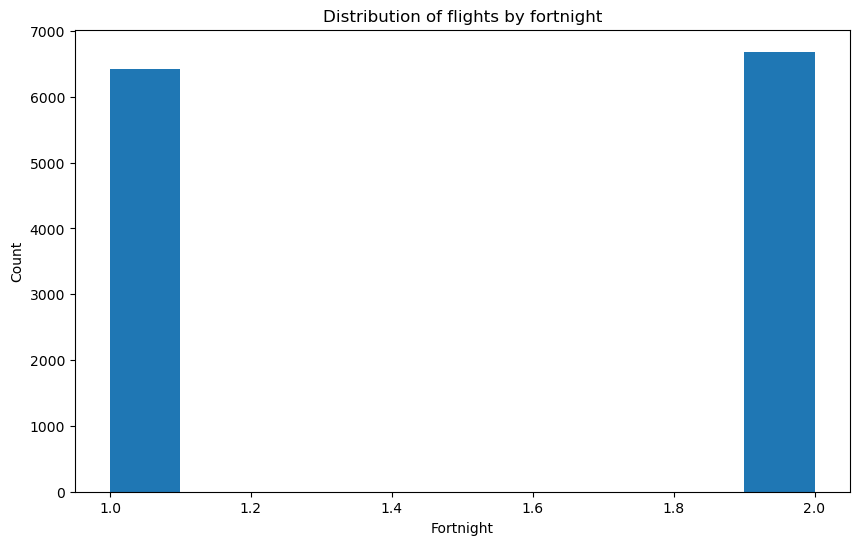

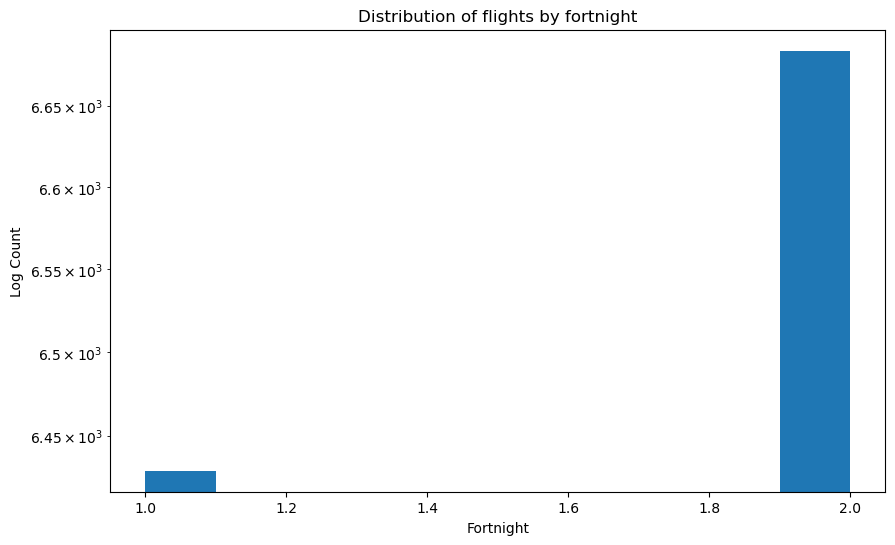

In [44]:
plot_histogram_of_column(flights["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, False)
plot_histogram_of_column(flights["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, True)

In this case, the difference is minimal. However, if we apply the logarithm to the y axis we can see that the second forntingh accumulates more flights than the first one.

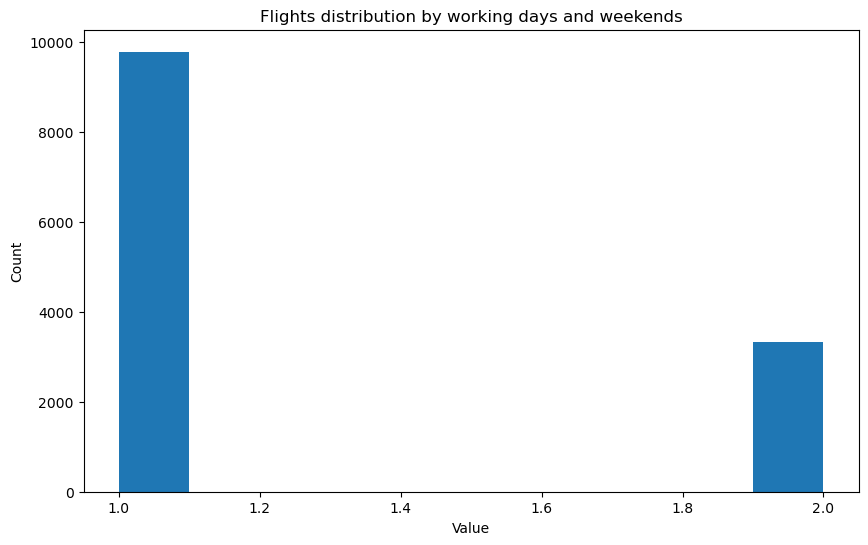

In [45]:
plot_histogram_of_column(flights["WEEK_INFO"], "Flights distribution by working days and weekends", None, None, False, False)

As it could be expected, weekdays accumulate almost three times more flights than weekends. However, we must keep in mind that the weekday category groups five days while the weekend only groups two days. Probably, the difference wouldn't be this big if we were plotting the average number of flights per day. However, this escapes from the scope of this project as it doesn't provide any additional information that could be helpful to predict flight delays.

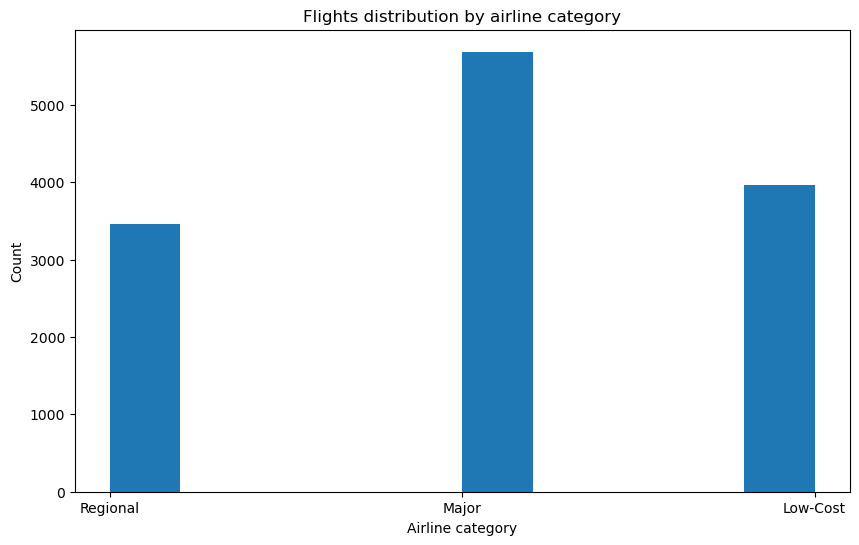

In [46]:
plot_histogram_of_column(flights["AC"], "Flights distribution by airline category", "Airline category", None, False, False)

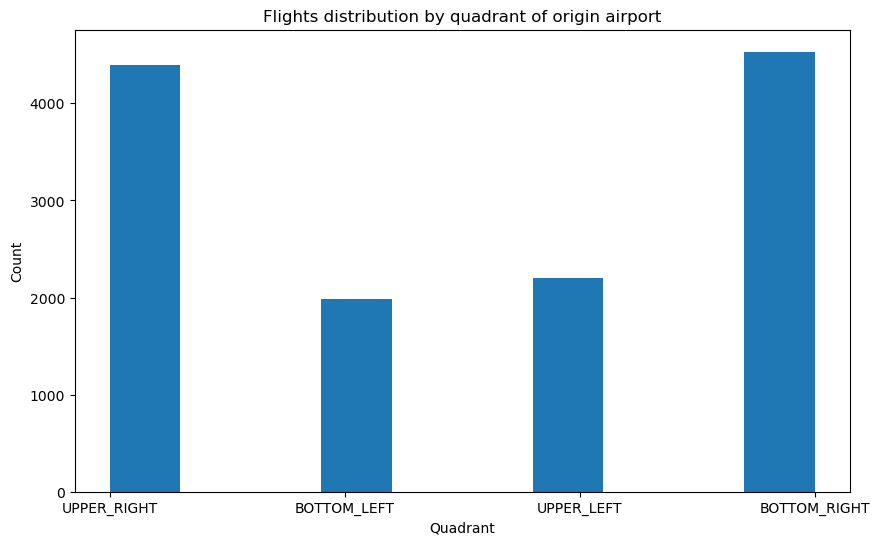

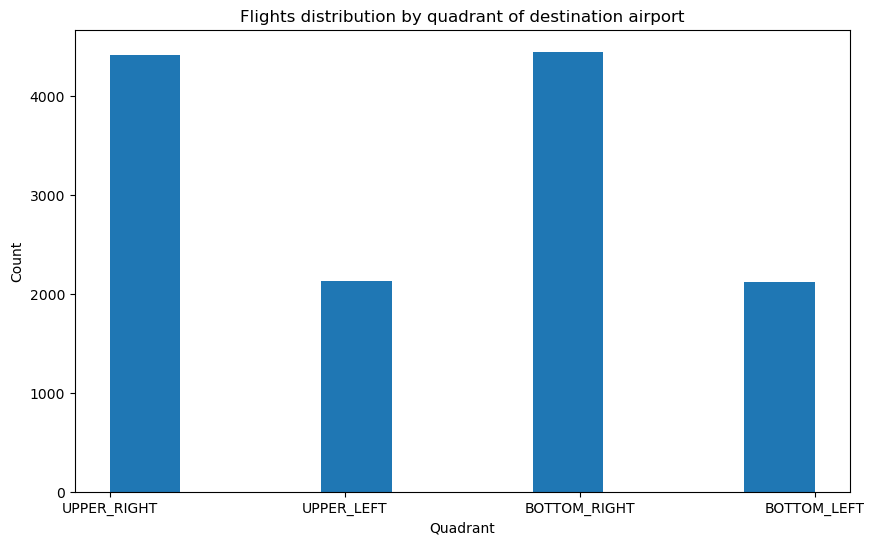

In [47]:
plot_histogram_of_column(flights["GR_O"], "Flights distribution by quadrant of origin airport", "Quadrant", None, False,False)

plot_histogram_of_column(flights["GR_D"], "Flights distribution by quadrant of destination airport", "Quadrant", None, False,False)

In both cases, the quadrants with the greater amount of flights are *UPPER_RIGHT* and *BOTTOM_RIGT*. This represents the east cost of the USA, where many of the biggest cities are located.

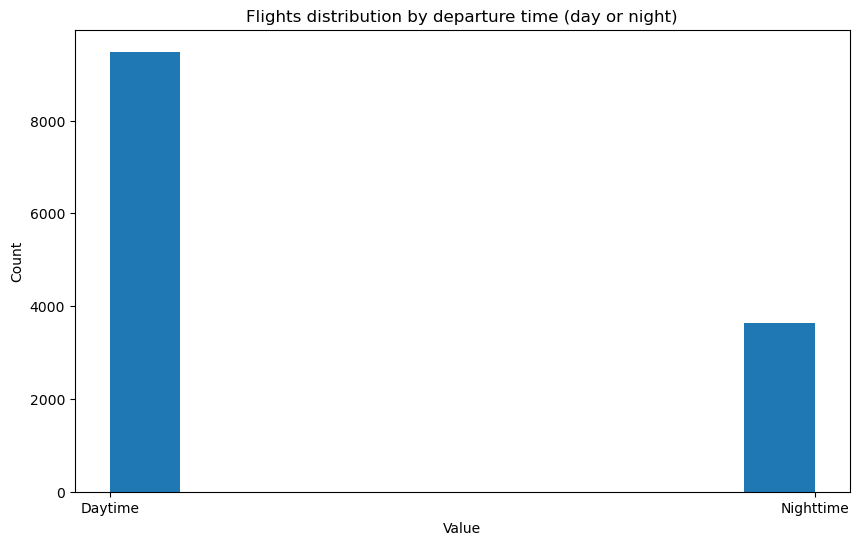

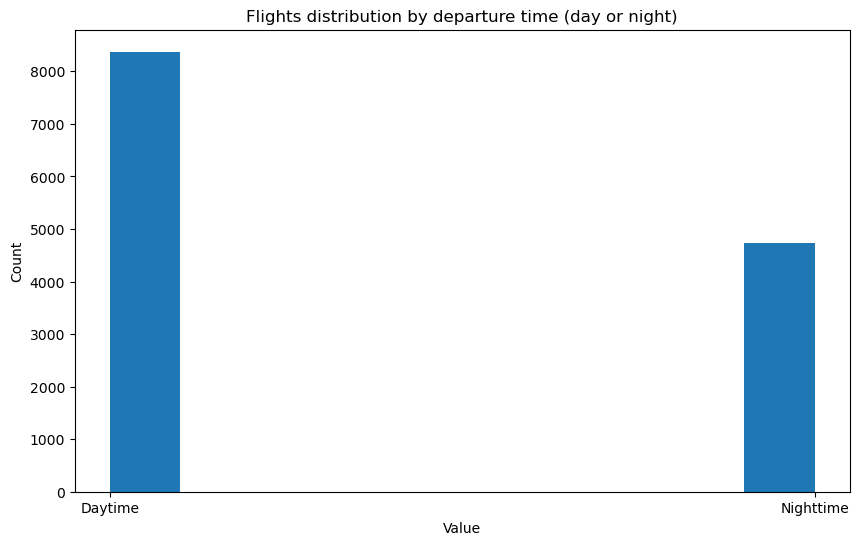

In [48]:
plot_histogram_of_column(flights["DepartureDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

plot_histogram_of_column(flights["ArrivalDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

Logically, most of the flights departure during daytime and this trend seems to hold for the arrival time. However, if we compare both histograms we will see that the amount of flights departing during daytime is considerably greater than the flights arriving during daytime. This mean that a considerable amount of flights arrive at their destination at night time even though day departed at daytime.

## Gauzanization of continuos variables

Since the models we will apply assume that our data is distributed following a gaussian distribution, we need to make sure that our data is gaussian.

First of all, we are going to determine which columns of our dataset are the ones containing continuous data

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

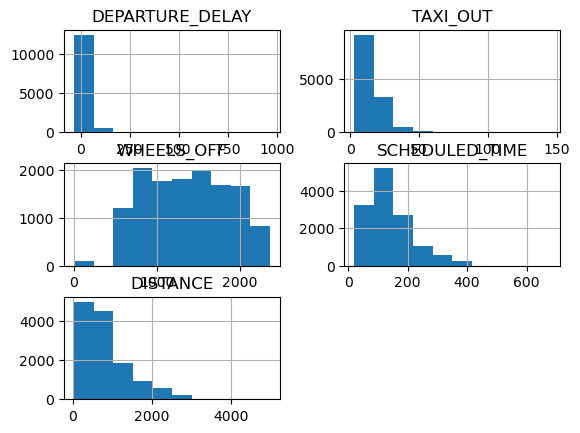

In [49]:
# Declare which variables are categorical and which ones are continuous. 

continuous = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE']

flights[continuous].hist()               

We see that our data doesn't follow a gaussian distribution. Before gaussianizing it, we will first remove any outliers that can be identified in the dataset.

In [50]:

def remove_outliers_zscore(data_series, threshold=3):
    """
    Remove outliers from a pandas Series using the Z-score method.
    :param data_series: a pandas Series containing the data
    :param threshold: the number of standard deviations from the mean at which to consider a data point an outlier
    :return: a new pandas Series with the outliers removed
    """
    z_scores = np.abs((data_series - data_series.mean()) / data_series.std())
    return data_series[z_scores <= threshold]


In [51]:

# Remove outliers (no outliers in the whole dataset, no need to modify X_train and X_test)
flights_cont = remove_outliers_zscore(flights[continuous])
len(flights_cont)

13113

It can be seen that no outliers are removed. We can now proceed with the normalization of the continuous data defined before.

In [52]:
# we normalize continuous variables
from sklearn.preprocessing import QuantileTransformer

# Initialize transformer with number of quantiles and output distribution
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

# Apply transformation to continuous columns
for col in continuous:
    flights[col] = transformer.fit_transform(flights[col].values.reshape(-1, 1))
    X_train[col] = transformer.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = transformer.fit_transform(X_test[col].values.reshape(-1, 1))

And we plot the normalized data, which now clearly follow a gaussian distribution.

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

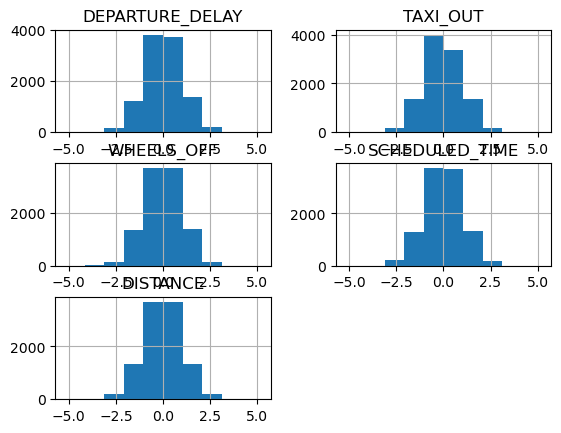

In [53]:
X_train[continuous].hist()

## One hot encodign of categorical variables

After dealing with the continuous variables, we will apply hot encoding to our categorical variables, which are:
- Q_year
- Fortnight
- Week_info
- Ac
- Gr_o
- Gr_d
- ArrivalDayNight
- DepartureDayNight

In [54]:
# one hot encoding for categorical variables
categorical = ['Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O','GR_D', 'ArrivalDayNight', 'DepartureDayNight']

flights= pd.get_dummies(flights, columns=categorical)
X_train = pd.get_dummies(X_train, columns = categorical)
X_test = pd.get_dummies(X_test, columns = categorical)

## Initial modelling

Lastly, we will start testing some initial models and check what accuracy are we getting. First of all we need to split our variables into features (i.e.: X) and target variable (i.e.: y). However recall that we already split before in order to infer from X_train which transformations may be necessary. 

After splitting the data, we can initialize the model we will be using to predict flight delays. Then, using the fraction of the data we have selected for this purpouse, we will fit the model.

In [56]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

LogisticRegression()

Once the model has been trained, we are abla to make predictions based on the testing data. This will produce a one-dimentional vector containing 1's or 0's depending on if the model believes that flight is going to be delayed or not.

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have already initialized and fitted your logistic regression model

# Perform cross-validation
cv_scores_accuracy = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1_macro')

# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Accuracy:", cv_scores_accuracy.mean())
print("Standard Deviation:", cv_scores_accuracy.std())

print("Cross-Validation F1 Scores:", cv_scores_f1)
print("Mean F1 Score:", cv_scores_f1.mean())
print("Standard Deviation:", cv_scores_f1.std())


Cross-Validation Accuracy Scores: [0.83698761 0.83984747 0.83460439 0.82268827 0.81696854]
Mean Accuracy: 0.8302192564346997
Standard Deviation: 0.008832209587721969
Cross-Validation F1 Scores: [0.8225727  0.82526929 0.82127256 0.80499228 0.80238153]
Mean F1 Score: 0.8152976721552498
Standard Deviation: 0.009602981341004659


We get an 83% of accuracy of mean, which is not bad at all specially when taking into account that only a small fraction of the available data has been used troughout the training and testing of the model.

Nextly we will check if getting a smaller subset of variables we can get better results: 

In [58]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Initialize the feature selection model
feature_selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='mean')

# Fit the feature selector on the training data
feature_selector.fit(X_train, y_train)

# Transform the training and test sets to include only the selected features
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# Get the selected feature indices
selected_feature_indices = feature_selector.get_support(indices=True)

# Get the original feature names for the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE'],
      dtype='object')


In [59]:
X_train_sf = X_train[selected_feature_names]
X_test_sf = X_test[selected_feature_names]

In [61]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train_sf, y_train)

LogisticRegression()

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have already initialized and fitted your logistic regression model

# Perform cross-validation
cv_scores_accuracy = cross_val_score(logreg, X_train_sf, y_train, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(logreg, X_train_sf, y_train, cv=5, scoring='f1_macro')

# Print the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Accuracy:", cv_scores_accuracy.mean())
print("Standard Deviation:", cv_scores_accuracy.std())

print("Cross-Validation F1 Scores:", cv_scores_f1)
print("Mean F1 Score:", cv_scores_f1.mean())
print("Standard Deviation:", cv_scores_f1.std())


Cross-Validation Accuracy Scores: [0.83317445 0.83651096 0.8250715  0.82173499 0.81172545]
Mean Accuracy: 0.8256434699714014
Standard Deviation: 0.008765074939159272
Cross-Validation F1 Scores: [0.81831471 0.82114188 0.81054187 0.80394385 0.79711529]
Mean F1 Score: 0.810211518807203
Standard Deviation: 0.008899871777217218


We observe that the model with all the features gives better predictions, but they are kind of similar, so we will keep both subset of variables since they both work good and this new subset is much smaller

## Metric for choosing models

To start with, we are going to decide which of the metrics to use in order to compare our models and decide which of them is the best. We firstly observe the balance between classes

In [68]:
import pandas as pd

# Assuming your target variable is stored in a DataFrame or Series named "y"
class_counts = y.value_counts()
class_balance = class_counts / len(y) * 100

print("Class Balance:")
print(class_balance)


Class Balance:
0    62.411348
1    37.588652
Name: DELAYED, dtype: float64


With class 0 at 62.41% and class 1 at 37.59%, there is a noticeable difference in class frequencies, but it does not indicate severe class imbalance. However, it is still worth considering the implications of the imbalance and how it might affect our modeling approach.

When dealing with imbalanced data, it is important to be aware that standard evaluation metrics like accuracy may not provide an accurate representation of model performance. Instead, we need to focus on metrics that are more robust to class imbalance, such as precision, recall, F1 score, or area under the ROC curve (AUC-ROC).

Nevertheless, since the imbalance is not that big, we will also consider the accuracy score in order to choose our models. We mainly will take into account the F1-score (taking into account then Recall and precision that will take into account the slightly unbalanced classes that we have). 


## Modeling 

To start with: We remember some of the options we have to optimize the learning of our models

**1. Hyperparameter Tuning**: Fine-tune the hyperparameters of your model to find the optimal combination for your specific problem. Use techniques like grid search, random search, or Bayesian optimization to systematically explore the hyperparameter space and identify the best configuration.


**2. Cross-Validation**: Utilize cross-validation techniques, such as k-fold cross-validation, to evaluate your model's performance more reliably. This helps to assess how well your model generalizes to unseen data and reduces the risk of overfitting.

**3. Regularization**: Apply regularization techniques like L1 or L2 regularization (e.g., LASSO, Ridge) to prevent overfitting. Regularization helps in reducing the complexity of the model by adding a penalty term to the loss function, promoting simpler models that generalize better.


**4. Ensemble Methods**: Explore ensemble methods like bagging, boosting, or stacking to combine multiple models and improve overall performance. Ensemble techniques can help capture different patterns in the data and reduce model variance.


**5. Data Augmentation**: If you have limited data, consider data augmentation techniques to artificially increase the size of your training set. This can involve techniques like rotation, flipping, zooming, or adding noise to your existing data.


**6. Early Stopping**: Implement early stopping during model training to prevent overfitting and find the optimal number of training epochs. Early stopping stops training when the model's performance on a validation set starts to deteriorate.


**7. Batch Normalization**: Apply batch normalization techniques to normalize the activations of the previous layer in 

**8. Model Architecture**: Experiment with different model architectures or network architectures, such as adding or removing layers, adjusting layer sizes, or trying different activation functions. It can help to explore pre-trained models or architectures specifically designed for your problem domain.


**9. Monitoring and Debugging**: Monitor your model during training, track performance metrics, and analyze learning curves to identify issues like underfitting, overfitting, or convergence problems. Debug any potential errors, explore misclassified samples, and consider adjusting your model or data accordingly.

In [79]:
# Create a data-frame to store results: 
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

## Support Vector Machine (SVC)
First of all we recall the hyperparameters we are going to tune:

1.C: Regularization parameter. It controls the trade-off between allowing training errors and maximizing the margin. Larger values of C penalize errors more, leading to a potentially narrower margin.

2.kernel: Specifies the type of kernel function used for mapping the input data to a higher-dimensional feature space. Common options include linear, polynomial, radial basis function (RBF), and sigmoid.

3.gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It defines the influence of training samples on the decision boundary.

We fit the SVC using the whole subset of features: 

In [80]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271


Now only using the best features: 

In [81]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078


Since we have very similar results, let us compute the hyperparameter tuning with the SVC using only the small part of data. 

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVC model
clf = SVC()

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best F1 Score: 0.8430095899394434


We now fit SVC using the hyperparameters that we found and using both datasets:

In [82]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='rbf', gamma = 'auto', C=10)
clf.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795


In [84]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(kernel='rbf', gamma = 'auto', C=10)
clf.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(clf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['SVC subset features after HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687


We are now observing that the subset of features is now doing better job than that of all the features surprisingly. The best combination is the last one we fitted.

#### Naive Bayes
The parameters GaussianNB are the following: Priors: Prior probabilities of the classes. If specified, the priors are not adjusted according to the data. Var_smoothing:Portion of the largest variance of all features that is added to variances for calculation stability.

However we are only going to tune var_smoothing:

To proceed, we are going to fit the Naive Bayes model for both subsets of the features: 

In [88]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
naive = GaussianNB()
naive.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385


In [90]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
naive = GaussianNB()
naive.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563


We now compute hyperparameter tuning using the smallest subset of features

In [92]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline
pipeline = Pipeline([
    ('classifier', GaussianNB())
])

param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.25 ,0.3 , 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'classifier__var_smoothing': 0.1}
Best Score:  0.8328884652049571


In [ ]:
We now fit the model using the best parameter we found: 

In [94]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
naive = GaussianNB(var_smoothing = 0.1)
naive.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468


In [95]:
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
naive = GaussianNB(var_smoothing = 0.1)
naive.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391


In this case the best model is by far the one using the subset of features (the other one is probably overfitting) and in this case the hyperparamter tuning hasn't been helpful since the F1 score has decreased and the accuracy has almost remained the same. Therefore we belief that the best model is that of Gaussian Naive Bayes subset features After HT.

#### LDA

Hyperparameters:

n_components: This hyperparameter specifies the number of components (dimensions) to retain after performing dimensionality reduction with LDA. By default, n_components is set to None, which means it will retain (n_classes - 1) components, where n_classes is the number of distinct classes in the data. In the param_grid, values of [None, 1, 2, 3] are provided to try different numbers of retained components. By setting n_components to a specific value, you can explicitly control the dimensionality of the reduced feature space.

shrinkage: Shrinkage is a regularization technique used to improve the estimation of the covariance matrix in LDA, especially when the number of samples is small or the covariance matrix is ill-conditioned. The shrinkage hyperparameter controls the degree of shrinkage applied. 
In the param_grid, the values [None, 'auto', 0.1, 0.5] are provided to try different levels of shrinkage:
None: No shrinkage is applied.
'auto': Shrinkage is estimated using the Ledoit-Wolf lemma, which automatically determines the amount of shrinkage based on the data.
0.1, 0.5: Specific values between 0 and 1 can be provided to manually set the shrinkage intensity.

solver: This hyperparameter specifies the solver used for LDA computation. LDA can be solved using different algorithms, and the solver parameter determines the specific algorithm to use. 
In the param_grid, the values ['svd', 'lsqr', 'eigen'] are provided to try different solver algorithms:
'svd': Singular Value Decomposition (SVD) solver, which computes the exact solution but can be slower for large datasets.
'lsqr': Least Squares solver, which can handle both shrinkage and regularized covariance matrix.
'eigen': Eigenvalue Decomposition solver, which computes the eigenvalues and eigenvectors of the covariance matrix.

We now fit the Linear Discriminant Analysis classifier for both subset of features: 

In [97]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.831459,0.816218,0.825102,0.810283


In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(lda , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.831459,0.816218,0.825102,0.810283


We now do hyperparameter tuning with the small subset of features dataset: 

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {
    'n_components': [None, 1, 2, 3],    # Values to try for n_components
    'shrinkage': [None, 'auto', 0.1, 0.5],    # Values to try for shrinkage
    'solver': ['svd', 'lsqr', 'eigen'],    # Values to try for solver
    'tol': [1e-6,1e-5,1e-4, 1e-3, 1e-2]    # Values to try for tol
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'n_components': None, 'shrinkage': None, 'solver': 'svd', 'tol': 1e-06}
Best Score:  0.8314585319351764


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
800 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/U

After hyperparameter tuning we fit the LDA with the hyperparameters we found: 

In [110]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
lda = LinearDiscriminantAnalysis(n_components = None,shrinkage = None,  solver = 'svd', tol = 1e-06)
lda.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [111]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(lda , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['LDA subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


#### Perceptron

We now fit the normal model for the perceptron:

Hyperparameters:

penalty: Specifies the penalty term used in the update rule to handle misclassifications. It can be set to 'l1', 'l2', or 'elasticnet'. The default value is 'l2'.

alpha: The constant that multiplies the penalty term if regularization is applied. It controls the strength of the regularization. The default value is 0.0001.

fit_intercept: Indicates whether an intercept term should be included in the model. If set to True, the perceptron learns an intercept term. The default value is True.

max_iter: The maximum number of passes over the training data (epochs) for training the perceptron. The default value is 1000.

tol: The tolerance for the stopping criterion. It specifies the minimum change in the average loss for training to continue. The default value is 1e-3.

shuffle: Determines whether to shuffle the training data before each epoch during training. The default value is True.

eta0: The initial learning rate. It controls the step size at each update during training. The default value is 1.0.

early_stopping: If set to True, training will stop when validation loss does not improve anymore. The default value is False.

validation_fraction: The proportion of training data to use for early stopping validation. The default value is 0.1.

n_iter_no_change: The maximum number of epochs to wait for the validation loss to improve when early_stopping is enabled. The default value is 5.

We now fit the models for both subsets of features: 

In [112]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Perceptron classifier
perceptron = Perceptron()
# Train the Perceptron classifier
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [113]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Perceptron classifier
perceptron = Perceptron()
# Train the Perceptron classifier
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


We now tune the hyper parameters using the smallest subset of features: 

In [118]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV

# Create a Perceptron classifier
perceptron = Perceptron()

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty type
    'alpha': [0.0001, 0.001, 0.01],         # Regularization parameter
    'max_iter': [1000, 2000, 3000],         # Maximum number of iterations
    'eta0': [0.1, 0.01, 0.001],             # Initial learning rate
    'tol': [10,1,1e-1,1e-2,1e-3]               # Tolerance for stopping criterion
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'alpha': 0.001, 'eta0': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 10}
Best Score:  0.8057197330791229


We now fit with the found hyperparameters:

In [119]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Perceptron classifier
perceptron = Perceptron(alpha = 0.001, eta0=0.1, max_iter=1000, penalty='elasticnet', tol=10)
# Train the Perceptron classifier
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df


,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [120]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a Perceptron classifier
perceptron = Perceptron(alpha = 0.001, eta0=0.1, max_iter=1000, penalty='elasticnet', tol=10)
# Train the Perceptron classifier
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Perceptron subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In this case we observe that the best model is by far the last we fitted: Perceptron subset features After HT, since it has the best accuracy and f1 score

## Gradient boost 

Hyperparameters:

n_estimators: The number of boosting stages to perform.

learning_rate: The learning rate or shrinkage parameter, which controls the contribution of each tree.

max_depth: The maximum depth of individual trees in the ensemble.

subsample: The subsample ratio of the training instances.

min_samples_split: The minimum number of samples required to split an internal node.

We fit the model for both subset of features: 


In [134]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
# Train the classifier
gb_classifier.fit(X_train, y_train)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [135]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
# Train the classifier
gb_classifier.fit(X_train_sf, y_train)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    #'n_estimators': [50, 100, 200],  # Number of boosting stages to perform
    #'learning_rate': [0.1, 0.01, 0.001],  # Learning rate (shrinkage parameter)
    'max_depth': [3, 4, 5],  # Maximum depth of individual trees
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'min_samples_split': [2, 3, 4]  # Minimum number of samples required to split an internal node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Hyperparameters: {'max_depth': 4, 'min_samples_split': 4, 'subsample': 0.8}
Best F1 Score: 0.8394708055874597


We now tune the left hyperparameters: 

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of boosting stages to perform
    'learning_rate': [1,0.1, 0.01, 0.001],  # Learning rate (shrinkage parameter)
    'max_depth': [4],  # Maximum depth of individual trees
    'subsample': [0.8],  # Subsample ratio of the training instances
    'min_samples_split': [3]  # Minimum number of samples required to split an internal node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 100, 'subsample': 0.8}
Best F1 Score: 0.8397310793851449


In [139]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100, subsample=0.8)
# Train the classifier
gb_classifier.fit(X_train, y_train)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [140]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_split=3, n_estimators=100, subsample=0.8)
# Train the classifier
gb_classifier.fit(X_train, y_train)
# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gradient Boost subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


We obtain slightly better results with the Gradient Boost subset features After HT. 

### Random forest
Hyperparameters:

n_estimators: The number of decision trees in the random forest. Increasing the number of estimators typically improves performance but increases computational complexity. It represents the ensemble size.

max_depth: The maximum depth of each decision tree in the forest. Higher values increase model complexity and can lead to overfitting.

min_samples_split: The minimum number of samples required to split an internal node. Larger values prevent overfitting by requiring a certain number of samples in each split.

min_samples_leaf: The minimum number of samples required to be at a leaf node. Similar to min_samples_split, larger values help control overfitting by requiring a minimum number of samples in each leaf.

max_features: The number of features to consider when looking for the best split. Reducing this number can help control overfitting. Values such as 'sqrt' or 'log2' can be used to consider a square root or logarithm of the total features, respectively.

bootstrap: Determines whether bootstrap samples are used when building trees. Setting it to True enables bootstrap sampling, while False disables it. Bootstrap sampling introduces randomness into the training process and helps improve model diversity.

criterion: The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We have an additional parameter (not to tune) : criterion: The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We first fit the normal model with both subset of features: 

In [143]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [144]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


We now proceed to do hyperparameter tuning with the small subset of features: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest classifier
random_forest = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    #'n_estimators': [100, 200, 500],
    #'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
    'criterion': ['gini', 'entropy']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)



In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest classifier
random_forest = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    #'n_estimators': [100, 200, 500],
    #'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2'],
    'bootstrap': [True],
    'random_state': [42],
    'criterion': ['gini']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42}


In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a Random Forest classifier
random_forest = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, None],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['log2'],
    'bootstrap': [True],
    'random_state': [42],
    'criterion': ['gini']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [150]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(bootstrap = True, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


In [151]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(bootstrap = True, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Random Forest subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


#### Neural Nets
Hyperparameters: 

Learning rate: The learning rate determines how much the weights are updated in response to the estimated error each time the model weights are updated. Choosing the right learning rate can be crucial as a value too small may result in a long training process that could get stuck, while a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

Optimizer: what type of optimizer you want to use

Batch size: This is the number of samples to work through before updating the internal model parameters. A smaller batch size can lead to more updates and potentially faster convergence, but it also introduces more variance, which can lead to instability in the learning process.

Activation function: Different activation functions can result in significant differences in the performance of a neural network. The Rectified Linear Unit (ReLU) and its variants (like Leaky ReLU, Parametric ReLU) are often a good starting point for many problems.

We now do some neural nets. 

In [177]:
# install needed packages for following modeling
!pip install scikeras

## Neural Network I 
Fit neural network with all the features: 

In [193]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [207]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network I all features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]



Epoch 1/10


2023-05-24 20:33:55.609002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4325 - accuracy: 0.8092
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3591 - accuracy: 0.8481
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3449 - accuracy: 0.8557
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8580
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8618
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3275 - accuracy: 0.8625
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3230 - accuracy: 0.8642
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3181 - accuracy: 0.8677
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8688
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:34:09.138132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:34:09.421337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4357 - accuracy: 0.8076
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3599 - accuracy: 0.8477
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8550
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8584
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3336 - accuracy: 0.8618
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3289 - accuracy: 0.8612
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8621
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8648
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8673
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:34:22.784284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:34:23.054705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4374 - accuracy: 0.7961
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3621 - accuracy: 0.8464
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3471 - accuracy: 0.8546
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8565
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8606
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.8620
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3236 - accuracy: 0.8646
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3221 - accuracy: 0.8668
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3178 - accuracy: 0.8663
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:34:36.534273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:34:36.826091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4358 - accuracy: 0.8023
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3540 - accuracy: 0.8497
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3399 - accuracy: 0.8615
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3322 - accuracy: 0.8608
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3263 - accuracy: 0.8637
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3207 - accuracy: 0.8699
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8699
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3118 - accuracy: 0.8695
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3090 - accuracy: 0.8687
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:34:50.862893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:34:51.153262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4334 - accuracy: 0.8043
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3599 - accuracy: 0.8494
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3446 - accuracy: 0.8563
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3382 - accuracy: 0.8589
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3321 - accuracy: 0.8622
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3290 - accuracy: 0.8643
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8640
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3198 - accuracy: 0.8668
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3167 - accuracy: 0.8668
Epoch 10/10
66/66 [==============================] - 0s 1ms/step


2023-05-24 20:35:04.985248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fit with the subset of variables: 

In [212]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=10, batch_size=32)

In [213]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network I subset features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]



Epoch 1/10


2023-05-24 20:38:42.304313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4341 - accuracy: 0.8130
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.8502
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3481 - accuracy: 0.8565
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3438 - accuracy: 0.8561
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3403 - accuracy: 0.8594
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3388 - accuracy: 0.8583
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3379 - accuracy: 0.8582
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3367 - accuracy: 0.8602
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8602
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:38:56.124400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:38:56.421478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4257 - accuracy: 0.8159
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3595 - accuracy: 0.8483
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3495 - accuracy: 0.8555
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3438 - accuracy: 0.8566
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3435 - accuracy: 0.8577
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3415 - accuracy: 0.8576
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3396 - accuracy: 0.8597
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.8584
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3400 - accuracy: 0.8588
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:39:10.068816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:39:10.362915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4403 - accuracy: 0.8051
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3623 - accuracy: 0.8468
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3504 - accuracy: 0.8519
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3471 - accuracy: 0.8556
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3431 - accuracy: 0.8575
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3421 - accuracy: 0.8550
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3399 - accuracy: 0.8574
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3396 - accuracy: 0.8571
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3396 - accuracy: 0.8564
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:39:24.293557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/263 [..............................] - ETA: 1:19 - loss: 0.6959 - accuracy: 0.4375

2023-05-24 20:39:24.574849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4150 - accuracy: 0.8199
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3498 - accuracy: 0.8572
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8606
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3349 - accuracy: 0.8601
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3340 - accuracy: 0.8605
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8646
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3293 - accuracy: 0.8640
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3291 - accuracy: 0.8622
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3278 - accuracy: 0.8622
Epoch 10/10
66/66 [==============================] - 0s 2ms/step
Epoch 1/10


2023-05-24 20:39:38.337303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 20:39:38.976980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 6ms/step - loss: 0.4232 - accuracy: 0.8160
Epoch 2/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3547 - accuracy: 0.8521
Epoch 3/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3449 - accuracy: 0.8577
Epoch 4/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3396 - accuracy: 0.8572
Epoch 5/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3375 - accuracy: 0.8580
Epoch 6/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8599
Epoch 7/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3346 - accuracy: 0.8601
Epoch 8/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3338 - accuracy: 0.8614
Epoch 9/10
263/263 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8608
Epoch 10/10
66/66 [==============================] - 0s 2ms/step


2023-05-24 20:39:52.696844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [214]:
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
SVC all features Before HT,0.833937,0.817714,0.829882,0.810271
SVC subset features Before HT,0.832793,0.816053,0.829476,0.808078
SVC all features After HT,0.858055,0.842509,0.862018,0.831795
SVC subset features after HT,0.860153,0.84301,0.870671,0.829687
Gaussian Naive Bayes Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes all features Before HT,0.767016,0.747318,0.752331,0.74385
Gaussian Naive Bayes subset features Before HT,0.832698,0.816219,0.828732,0.808563
Gaussian Naive Bayes all features After HT,0.787703,0.764991,0.779569,0.757468
Gaussian Naive Bayes subset features After HT,0.832888,0.814109,0.833829,0.80391
LDA all features Before HT,0.828122,0.812401,0.821662,0.806338


Since we observe that the subset of features works better, we will do hyperparameter tuning using a the subset of the features: 

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

# Define the hyperparameters and their respective values to tune
param_grid = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)],
    'batch_size': [32, 64, 96],
    'epochs': [50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train_sf, y_train)

In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Now lets fit the model that has the best hyperparameters we found: 

## Neural Network II
We firstly fit the neural network with both subsests of features.



With all the features: 

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=30, batch_size=32)

In [ ]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II all features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Hyper-parameter tuning with all features: 

In [226]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

# Define the hyperparameters and their respective values to tune
param_grid = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)],
    'batch_size': [32, 64, 96],
    'epochs': [50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)



Epoch 1/50


/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:06:17.974835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.4614 - accuracy: 0.7908
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3635 - accuracy: 0.8470
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3473 - accuracy: 0.8568
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8620
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3346 - accuracy: 0.8644
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8651
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3275 - accuracy: 0.8665
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3234 - accuracy: 0.8659
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.8683
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3184 - accuracy: 0.8706
Epoch 11/5

2023-05-24 22:07:22.170838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:07:22.452516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3930 - accuracy: 0.8295
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3492 - accuracy: 0.8509
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3395 - accuracy: 0.8576
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3329 - accuracy: 0.8596
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.8614
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3249 - accuracy: 0.8646
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3209 - accuracy: 0.8639
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3180 - accuracy: 0.8659
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3138 - accuracy: 0.8696
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3133 - accuracy: 0.8702
Epoch 11/5

2023-05-24 22:08:28.510396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:08:28.828648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3891 - accuracy: 0.8314
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3486 - accuracy: 0.8520
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3388 - accuracy: 0.8565
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8588
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3289 - accuracy: 0.8636
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3268 - accuracy: 0.8656
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3232 - accuracy: 0.8656
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3189 - accuracy: 0.8687
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3159 - accuracy: 0.8679
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3133 - accuracy: 0.8680
Epoch 11/5

2023-05-24 22:09:35.331520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:09:35.615800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3796 - accuracy: 0.8344
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8595
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3318 - accuracy: 0.8632
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3259 - accuracy: 0.8669
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3201 - accuracy: 0.8659
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3150 - accuracy: 0.8692
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3126 - accuracy: 0.8713
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3091 - accuracy: 0.8733
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3057 - accuracy: 0.8746
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3036 - accuracy: 0.8735
Epoch 11/5

2023-05-24 22:10:43.200337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:10:43.522209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3853 - accuracy: 0.8350
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3460 - accuracy: 0.8539
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3354 - accuracy: 0.8615
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3295 - accuracy: 0.8633
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8652
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3235 - accuracy: 0.8676
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3189 - accuracy: 0.8688
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3157 - accuracy: 0.8694
Epoch 9/50
263/263 [==============================] - 1s 6ms/step - loss: 0.3150 - accuracy: 0.8700
Epoch 10/50
263/263 [==============================] - 2s 6ms/step - loss: 0.3102 - accuracy: 0.8729
Epoch 11/5

2023-05-24 22:11:52.404724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:11:52.734718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3971 - accuracy: 0.8282
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3463 - accuracy: 0.8551
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8571
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3325 - accuracy: 0.8601
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3284 - accuracy: 0.8601
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3247 - accuracy: 0.8634
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3214 - accuracy: 0.8679
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3177 - accuracy: 0.8679
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3157 - accuracy: 0.8677
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3120 - accuracy: 0.8699
Epoch 11/5

2023-05-24 22:13:01.224672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:13:01.554819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3954 - accuracy: 0.8254
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3493 - accuracy: 0.8516
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3410 - accuracy: 0.8555
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3339 - accuracy: 0.8612
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3287 - accuracy: 0.8633
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3234 - accuracy: 0.8679
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3194 - accuracy: 0.8674
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3158 - accuracy: 0.8683
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3130 - accuracy: 0.8699
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3088 - accuracy: 0.8714
Epoch 11/5

2023-05-24 22:14:08.547124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:14:08.842268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3973 - accuracy: 0.8211
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3523 - accuracy: 0.8506
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3427 - accuracy: 0.8543
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3368 - accuracy: 0.8570
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8602
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3290 - accuracy: 0.8633
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.8648
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3207 - accuracy: 0.8676
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3181 - accuracy: 0.8680
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3156 - accuracy: 0.8687
Epoch 11/5

2023-05-24 22:15:16.055401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:15:16.344243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3827 - accuracy: 0.8346
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3392 - accuracy: 0.8570
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3307 - accuracy: 0.8631
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3241 - accuracy: 0.8669
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3186 - accuracy: 0.8680
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3149 - accuracy: 0.8679
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3128 - accuracy: 0.8692
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3096 - accuracy: 0.8699
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3055 - accuracy: 0.8726
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3031 - accuracy: 0.8755
Epoch 11/5

2023-05-24 22:16:23.337701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:16:23.653265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3931 - accuracy: 0.8246
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3437 - accuracy: 0.8568
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8597
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8611
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3239 - accuracy: 0.8650
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3208 - accuracy: 0.8670
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8661
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3130 - accuracy: 0.8695
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3108 - accuracy: 0.8705
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3082 - accuracy: 0.8732
Epoch 11/5

2023-05-24 22:17:30.393477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:17:30.701149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 9ms/step - loss: 0.4041 - accuracy: 0.8234
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3520 - accuracy: 0.8520
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8592
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3355 - accuracy: 0.8630
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3287 - accuracy: 0.8656
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3252 - accuracy: 0.8657
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.8664
Epoch 8/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3174 - accuracy: 0.8692
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3167 - accuracy: 0.8694
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3134 - accuracy: 0.8706
Epoch 11/5

2023-05-24 22:18:06.251641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:18:06.505568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4085 - accuracy: 0.8217
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3534 - accuracy: 0.8494
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3425 - accuracy: 0.8534
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3344 - accuracy: 0.8583
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3279 - accuracy: 0.8617
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3228 - accuracy: 0.8611
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3214 - accuracy: 0.8626
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3168 - accuracy: 0.8639
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8668
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3094 - accuracy: 0.8683
Epoch 11/

2023-05-24 22:18:41.367949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:18:41.622265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 9ms/step - loss: 0.3907 - accuracy: 0.8310
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3500 - accuracy: 0.8478
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3386 - accuracy: 0.8571
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3331 - accuracy: 0.8606
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3286 - accuracy: 0.8593
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3260 - accuracy: 0.8627
Epoch 7/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3215 - accuracy: 0.8656
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3176 - accuracy: 0.8656
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3145 - accuracy: 0.8675
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3123 - accuracy: 0.8677
Epoch 11/5

2023-05-24 22:19:16.173297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:19:16.443386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 9ms/step - loss: 0.4035 - accuracy: 0.8183
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3443 - accuracy: 0.8571
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3335 - accuracy: 0.8618
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3265 - accuracy: 0.8645
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3216 - accuracy: 0.8655
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3171 - accuracy: 0.8667
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3134 - accuracy: 0.8701
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3105 - accuracy: 0.8724
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3088 - accuracy: 0.8713
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3049 - accuracy: 0.8735
Epoch 11/5

2023-05-24 22:19:51.547268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:19:52.478572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 3s 11ms/step - loss: 0.4097 - accuracy: 0.8189
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3498 - accuracy: 0.8522
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3381 - accuracy: 0.8614
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3313 - accuracy: 0.8652
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8658
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8649
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3185 - accuracy: 0.8700
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3167 - accuracy: 0.8699
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3141 - accuracy: 0.8683
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3128 - accuracy: 0.8711
Epoch 11/

2023-05-24 22:20:28.188323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:20:28.473468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4022 - accuracy: 0.8253
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3491 - accuracy: 0.8556
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3421 - accuracy: 0.8564
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3336 - accuracy: 0.8603
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8637
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3242 - accuracy: 0.8657
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3212 - accuracy: 0.8659
Epoch 8/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3199 - accuracy: 0.8656
Epoch 9/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3143 - accuracy: 0.8680
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3129 - accuracy: 0.8683
Epoch 11/

2023-05-24 22:21:03.519908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:21:03.799901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4151 - accuracy: 0.8082
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3557 - accuracy: 0.8495
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3432 - accuracy: 0.8549
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3351 - accuracy: 0.8566
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3315 - accuracy: 0.8596
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3312 - accuracy: 0.8595
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3234 - accuracy: 0.8648
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.8644
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3192 - accuracy: 0.8682
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8682
Epoch 11/

2023-05-24 22:21:38.951531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:21:39.236395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4105 - accuracy: 0.8209
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3552 - accuracy: 0.8488
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3488 - accuracy: 0.8519
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3376 - accuracy: 0.8600
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3331 - accuracy: 0.8594
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3315 - accuracy: 0.8607
Epoch 7/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3269 - accuracy: 0.8645
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3245 - accuracy: 0.8652
Epoch 9/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3221 - accuracy: 0.8643
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3196 - accuracy: 0.8663
Epoch 11/

2023-05-24 22:22:14.691329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:22:14.973475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3918 - accuracy: 0.8286
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3420 - accuracy: 0.8565
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.8633
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3237 - accuracy: 0.8652
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3199 - accuracy: 0.8665
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3148 - accuracy: 0.8683
Epoch 7/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.8676
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3098 - accuracy: 0.8717
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3073 - accuracy: 0.8719
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3029 - accuracy: 0.8738
Epoch 11/

2023-05-24 22:22:50.674443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:22:50.944579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 11ms/step - loss: 0.3910 - accuracy: 0.8316
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3403 - accuracy: 0.8555
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3314 - accuracy: 0.8607
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3283 - accuracy: 0.8632
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3231 - accuracy: 0.8655
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3196 - accuracy: 0.8702
Epoch 7/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3187 - accuracy: 0.8695
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3149 - accuracy: 0.8705
Epoch 9/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3123 - accuracy: 0.8696
Epoch 10/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3107 - accuracy: 0.8686
Epoch 11/

2023-05-24 22:23:27.129832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:23:27.406273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step - loss: 0.4087 - accuracy: 0.8194
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3514 - accuracy: 0.8533
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3408 - accuracy: 0.8587
Epoch 4/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3340 - accuracy: 0.8595
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3295 - accuracy: 0.8633
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3271 - accuracy: 0.8643
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3232 - accuracy: 0.8649
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3204 - accuracy: 0.8680
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3169 - accuracy: 0.8695
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3153 - accuracy: 0.8706
Epoch 11/50
88/88 [==========

2023-05-24 22:23:51.140217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:23:51.397566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step - loss: 0.4234 - accuracy: 0.8061
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3554 - accuracy: 0.8471
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3415 - accuracy: 0.8552
Epoch 4/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3384 - accuracy: 0.8581
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3301 - accuracy: 0.8638
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3258 - accuracy: 0.8639
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3237 - accuracy: 0.8655
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3197 - accuracy: 0.8663
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3175 - accuracy: 0.8670
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3134 - accuracy: 0.8708
Epoch 11/50
88/88 [==========

2023-05-24 22:24:15.019385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:24:15.259587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4227 - accuracy: 0.8105
Epoch 2/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3544 - accuracy: 0.8474
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3466 - accuracy: 0.8528
Epoch 4/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3404 - accuracy: 0.8564
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3348 - accuracy: 0.8595
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3329 - accuracy: 0.8597
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3320 - accuracy: 0.8602
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3251 - accuracy: 0.8646
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3252 - accuracy: 0.8606
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3216 - accuracy: 0.8650
Epoch 11/50
88/88 [==========

2023-05-24 22:24:39.127950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:24:39.389986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4062 - accuracy: 0.8234
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3468 - accuracy: 0.8505
Epoch 3/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3349 - accuracy: 0.8607
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3256 - accuracy: 0.8662
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3217 - accuracy: 0.8665
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3186 - accuracy: 0.8689
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3167 - accuracy: 0.8713
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3125 - accuracy: 0.8698
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3083 - accuracy: 0.8740
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3066 - accuracy: 0.8730
Epoch 11/50
88/88 [==========

2023-05-24 22:25:03.354151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:25:03.610167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4157 - accuracy: 0.8108
Epoch 2/50
88/88 [==============================] - 1s 7ms/step - loss: 0.3517 - accuracy: 0.8516
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3379 - accuracy: 0.8599
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3326 - accuracy: 0.8614
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3287 - accuracy: 0.8617
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3243 - accuracy: 0.8673
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3206 - accuracy: 0.8673
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3183 - accuracy: 0.8677
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3135 - accuracy: 0.8713
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3119 - accuracy: 0.8727
Epoch 11/50
88/88 [==========

2023-05-24 22:25:28.342231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:25:28.626464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step - loss: 0.4193 - accuracy: 0.8133
Epoch 2/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3489 - accuracy: 0.8537
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3411 - accuracy: 0.8561
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3340 - accuracy: 0.8608
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3304 - accuracy: 0.8624
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3260 - accuracy: 0.8633
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3226 - accuracy: 0.8673
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3217 - accuracy: 0.8661
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3168 - accuracy: 0.8675
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3155 - accuracy: 0.8690
Epoch 11/50
88/88 [==========

2023-05-24 22:25:52.527268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:25:52.781885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4107 - accuracy: 0.8233
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3542 - accuracy: 0.8493
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3430 - accuracy: 0.8580
Epoch 4/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3378 - accuracy: 0.8595
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3332 - accuracy: 0.8592
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3265 - accuracy: 0.8631
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3248 - accuracy: 0.8662
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3214 - accuracy: 0.8651
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3210 - accuracy: 0.8658
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3160 - accuracy: 0.8681
Epoch 11/50
88/88 [==========

2023-05-24 22:26:16.843081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:26:17.098243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4164 - accuracy: 0.8142
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3531 - accuracy: 0.8509
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3428 - accuracy: 0.8553
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3363 - accuracy: 0.8584
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3327 - accuracy: 0.8602
Epoch 6/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3277 - accuracy: 0.8628
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3243 - accuracy: 0.8639
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3217 - accuracy: 0.8640
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3165 - accuracy: 0.8688
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3134 - accuracy: 0.8676
Epoch 11/50
88/88 [==========

2023-05-24 22:26:40.507529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:26:40.776018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4098 - accuracy: 0.8223
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3516 - accuracy: 0.8518
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.8570
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3308 - accuracy: 0.8618
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3268 - accuracy: 0.8633
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3235 - accuracy: 0.8636
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3195 - accuracy: 0.8648
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3146 - accuracy: 0.8692
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3122 - accuracy: 0.8698
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3094 - accuracy: 0.8706
Epoch 11/50
88/88 [==========

2023-05-24 22:27:04.663345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:27:04.929428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4079 - accuracy: 0.8158
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3486 - accuracy: 0.8544
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3387 - accuracy: 0.8597
Epoch 4/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3345 - accuracy: 0.8620
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3292 - accuracy: 0.8646
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3255 - accuracy: 0.8653
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3207 - accuracy: 0.8676
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3173 - accuracy: 0.8705
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3172 - accuracy: 0.8681
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3143 - accuracy: 0.8698
Epoch 11/50
88/88 [==========

2023-05-24 22:27:29.007584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:27:29.244683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 2s 9ms/step - loss: 0.4012 - accuracy: 0.8255
Epoch 2/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3488 - accuracy: 0.8548
Epoch 3/50
164/164 [==============================] - 1s 6ms/step - loss: 0.3365 - accuracy: 0.8601
Epoch 4/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3329 - accuracy: 0.8601
Epoch 5/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3279 - accuracy: 0.8636
Epoch 6/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3251 - accuracy: 0.8617
Epoch 7/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3236 - accuracy: 0.8653
Epoch 8/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3206 - accuracy: 0.8655
Epoch 9/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3169 - accuracy: 0.8687
Epoch 10/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3142 - accuracy: 0.8684
Epoch 11/5

GridSearchCV(cv=5,
             estimator=KerasClassifier(batch_size=32, build_fn=<function create_model at 0x42c558670>, epochs=30),
             param_grid={'batch_size': [32, 64, 96], 'epochs': [50],
                         'optimizer': [<keras.optimizers.optimizer_v2.adam.Adam object at 0x3c2c3cd30>,
                                       <keras.optimizers.optimizer_v2.adam.Adam object at 0x3c2c3c820>]},
             refit='f1_macro',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [228]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 64, 'epochs': 50, 'optimizer': <keras.optimizers.optimizer_v2.adam.Adam object at 0x3c2c3cd30>}


Fit the model with small subset of features

In [231]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=50, batch_size=64, optimizer=Adam(learning_rate=0.001))

In [232]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II subset features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Epoch 1/50


2023-05-24 22:32:43.021296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 9ms/step - loss: 0.4758 - accuracy: 0.7996
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3813 - accuracy: 0.8363
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3608 - accuracy: 0.8493
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3516 - accuracy: 0.8547
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8541
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3439 - accuracy: 0.8587
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3411 - accuracy: 0.8603
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3404 - accuracy: 0.8588
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8602
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3387 - accuracy: 0.8583
Epoch 11/5

2023-05-24 22:33:16.635692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 22:33:16.925359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4652 - accuracy: 0.7946
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3791 - accuracy: 0.8394
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3623 - accuracy: 0.8500
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3528 - accuracy: 0.8528
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3495 - accuracy: 0.8531
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8543
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3451 - accuracy: 0.8568
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3433 - accuracy: 0.8541
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3418 - accuracy: 0.8571
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3410 - accuracy: 0.8569
Epoch 11/

2023-05-24 22:33:50.856342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 22:33:51.102486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4806 - accuracy: 0.7854
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3813 - accuracy: 0.8363
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3618 - accuracy: 0.8477
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3537 - accuracy: 0.8494
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3491 - accuracy: 0.8540
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3448 - accuracy: 0.8563
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3433 - accuracy: 0.8552
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3421 - accuracy: 0.8543
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8586
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3402 - accuracy: 0.8557
Epoch 11/

2023-05-24 22:34:25.384690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 22:34:25.664220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4875 - accuracy: 0.7890
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3720 - accuracy: 0.8425
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3505 - accuracy: 0.8566
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3406 - accuracy: 0.8617
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3361 - accuracy: 0.8620
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3332 - accuracy: 0.8601
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3315 - accuracy: 0.8624
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3302 - accuracy: 0.8640
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3289 - accuracy: 0.8630
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3282 - accuracy: 0.8650
Epoch 11/

2023-05-24 22:35:00.629499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 22:35:00.886216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4779 - accuracy: 0.7815
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3812 - accuracy: 0.8335
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3605 - accuracy: 0.8501
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3504 - accuracy: 0.8528
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3449 - accuracy: 0.8583
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8569
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8593
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3363 - accuracy: 0.8600
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3362 - accuracy: 0.8592
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8606
Epoch 11/

2023-05-24 22:35:35.647436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyper-parameter tuning with subset of features: 

In [233]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

# Define the hyperparameters and their respective values to tune
param_grid = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)],
    'batch_size': [32, 64, 96],
    'epochs': [50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train_sf, y_train)



Epoch 1/50


/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:41:13.853214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.4457 - accuracy: 0.8009
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3622 - accuracy: 0.8497
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3485 - accuracy: 0.8564
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3421 - accuracy: 0.8613
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8599
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3392 - accuracy: 0.8601
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3374 - accuracy: 0.8597
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3357 - accuracy: 0.8607
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3354 - accuracy: 0.8608
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3333 - accuracy: 0.8612
Epoch 11/5

2023-05-24 22:42:18.874961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:42:19.193528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3838 - accuracy: 0.8346
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3479 - accuracy: 0.8558
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3445 - accuracy: 0.8572
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3413 - accuracy: 0.8570
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8578
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3383 - accuracy: 0.8596
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3375 - accuracy: 0.8587
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3374 - accuracy: 0.8578
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8601
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3360 - accuracy: 0.8582
Epoch 11/5

2023-05-24 22:43:25.396228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:43:25.710255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 2s 7ms/step - loss: 0.3821 - accuracy: 0.8354
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3504 - accuracy: 0.8510
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3453 - accuracy: 0.8559
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3417 - accuracy: 0.8545
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3406 - accuracy: 0.8556
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3393 - accuracy: 0.8578
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3389 - accuracy: 0.8592
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3382 - accuracy: 0.8599
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3370 - accuracy: 0.8589
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3367 - accuracy: 0.8588
Epoch 11/5

2023-05-24 22:44:33.090715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:44:33.410237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3767 - accuracy: 0.8384
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8606
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3340 - accuracy: 0.8607
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3307 - accuracy: 0.8625
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3301 - accuracy: 0.8640
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3283 - accuracy: 0.8646
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3273 - accuracy: 0.8645
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3272 - accuracy: 0.8639
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3252 - accuracy: 0.8679
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3261 - accuracy: 0.8653
Epoch 11/5

2023-05-24 22:45:41.431133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:45:42.419404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3775 - accuracy: 0.8401
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3452 - accuracy: 0.8555
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3393 - accuracy: 0.8577
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3362 - accuracy: 0.8589
Epoch 5/50
263/263 [==============================] - 1s 6ms/step - loss: 0.3356 - accuracy: 0.8615
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3345 - accuracy: 0.8617
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3335 - accuracy: 0.8636
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8632
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3312 - accuracy: 0.8632
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3323 - accuracy: 0.8608
Epoch 11/5

2023-05-24 22:46:51.277610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:46:51.595972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3865 - accuracy: 0.8358
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3461 - accuracy: 0.8565
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3419 - accuracy: 0.8575
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8597
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3382 - accuracy: 0.8586
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3372 - accuracy: 0.8599
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3355 - accuracy: 0.8614
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3349 - accuracy: 0.8614
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3349 - accuracy: 0.8595
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3337 - accuracy: 0.8608
Epoch 11/5

2023-05-24 22:48:00.552107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:48:00.884416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3877 - accuracy: 0.8354
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3515 - accuracy: 0.8510
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3454 - accuracy: 0.8561
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3437 - accuracy: 0.8553
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.8572
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8581
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3382 - accuracy: 0.8595
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8576
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3371 - accuracy: 0.8605
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8594
Epoch 11/5

2023-05-24 22:49:08.458991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:49:08.768094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3823 - accuracy: 0.8389
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3483 - accuracy: 0.8521
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3448 - accuracy: 0.8547
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8569
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8552
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3393 - accuracy: 0.8576
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3377 - accuracy: 0.8583
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3379 - accuracy: 0.8578
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8575
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3359 - accuracy: 0.8577
Epoch 11/5

2023-05-24 22:50:16.863695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:50:17.187618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3809 - accuracy: 0.8359
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3448 - accuracy: 0.8570
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8601
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8619
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3305 - accuracy: 0.8607
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3297 - accuracy: 0.8619
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3262 - accuracy: 0.8667
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3264 - accuracy: 0.8645
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3266 - accuracy: 0.8633
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8639
Epoch 11/5

2023-05-24 22:51:24.991091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:51:25.308484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 3s 8ms/step - loss: 0.3818 - accuracy: 0.8364
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3450 - accuracy: 0.8576
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8586
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3370 - accuracy: 0.8628
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3351 - accuracy: 0.8597
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3340 - accuracy: 0.8617
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3328 - accuracy: 0.8642
Epoch 8/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8615
Epoch 9/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3306 - accuracy: 0.8632
Epoch 10/50
263/263 [==============================] - 1s 5ms/step - loss: 0.3311 - accuracy: 0.8646
Epoch 11/5

2023-05-24 22:52:34.752047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50


2023-05-24 22:52:35.062575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3990 - accuracy: 0.8258
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3497 - accuracy: 0.8561
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3433 - accuracy: 0.8576
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8589
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3386 - accuracy: 0.8575
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8609
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8603
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8614
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3343 - accuracy: 0.8606
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3344 - accuracy: 0.8617
Epoch 11/

2023-05-24 22:53:10.294860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:53:10.568545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3978 - accuracy: 0.8290
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3503 - accuracy: 0.8531
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3438 - accuracy: 0.8545
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3418 - accuracy: 0.8559
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3405 - accuracy: 0.8553
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3389 - accuracy: 0.8580
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3377 - accuracy: 0.8599
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3363 - accuracy: 0.8593
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3363 - accuracy: 0.8583
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3360 - accuracy: 0.8581
Epoch 11/

2023-05-24 22:53:45.754807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:53:46.024670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 11ms/step - loss: 0.3967 - accuracy: 0.8296
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3537 - accuracy: 0.8546
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3460 - accuracy: 0.8557
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3444 - accuracy: 0.8564
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3411 - accuracy: 0.8566
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8578
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8564
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3368 - accuracy: 0.8596
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8588
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8569
Epoch 11/

2023-05-24 22:54:21.264850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:54:21.537763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 11ms/step - loss: 0.3959 - accuracy: 0.8275
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3426 - accuracy: 0.8581
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3346 - accuracy: 0.8618
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8597
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3295 - accuracy: 0.8631
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3284 - accuracy: 0.8657
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3274 - accuracy: 0.8652
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3259 - accuracy: 0.8657
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3257 - accuracy: 0.8649
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3249 - accuracy: 0.8659
Epoch 11/

2023-05-24 22:54:56.672810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:54:56.946130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3966 - accuracy: 0.8285
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3456 - accuracy: 0.8570
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3396 - accuracy: 0.8571
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3359 - accuracy: 0.8580
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3337 - accuracy: 0.8615
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3334 - accuracy: 0.8607
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3321 - accuracy: 0.8622
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3309 - accuracy: 0.8631
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3314 - accuracy: 0.8621
Epoch 10/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3306 - accuracy: 0.8640
Epoch 11/

2023-05-24 22:55:32.381509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:55:32.667291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3967 - accuracy: 0.8279
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3497 - accuracy: 0.8557
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3453 - accuracy: 0.8575
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3412 - accuracy: 0.8564
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3389 - accuracy: 0.8608
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8590
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8607
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3359 - accuracy: 0.8603
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8611
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3342 - accuracy: 0.8603
Epoch 11/

2023-05-24 22:56:07.859423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:56:08.141355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4064 - accuracy: 0.8246
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3547 - accuracy: 0.8508
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3469 - accuracy: 0.8546
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3437 - accuracy: 0.8572
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3411 - accuracy: 0.8597
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8593
Epoch 7/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3384 - accuracy: 0.8587
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8602
Epoch 9/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3365 - accuracy: 0.8608
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3371 - accuracy: 0.8605
Epoch 11/

2023-05-24 22:56:43.407428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:56:43.691042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4036 - accuracy: 0.8233
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3526 - accuracy: 0.8568
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3471 - accuracy: 0.8547
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3434 - accuracy: 0.8552
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8566
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3409 - accuracy: 0.8572
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3391 - accuracy: 0.8559
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3388 - accuracy: 0.8601
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8593
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3364 - accuracy: 0.8601
Epoch 11/

2023-05-24 22:57:19.158074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:57:19.439552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3905 - accuracy: 0.8320
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3407 - accuracy: 0.8587
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3351 - accuracy: 0.8596
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.8644
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3310 - accuracy: 0.8638
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3293 - accuracy: 0.8657
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3273 - accuracy: 0.8645
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3269 - accuracy: 0.8651
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3253 - accuracy: 0.8661
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3257 - accuracy: 0.8668
Epoch 11/

2023-05-24 22:57:54.324747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:57:54.606082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.3945 - accuracy: 0.8348
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3481 - accuracy: 0.8538
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3422 - accuracy: 0.8583
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3384 - accuracy: 0.8605
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8602
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8626
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8607
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3327 - accuracy: 0.8624
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3326 - accuracy: 0.8621
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.8619
Epoch 11/

2023-05-24 22:58:29.885016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:58:30.177292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 14ms/step - loss: 0.4072 - accuracy: 0.8216
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3508 - accuracy: 0.8562
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3438 - accuracy: 0.8558
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3409 - accuracy: 0.8581
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3388 - accuracy: 0.8593
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3381 - accuracy: 0.8601
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3361 - accuracy: 0.8601
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3355 - accuracy: 0.8582
Epoch 9/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3351 - accuracy: 0.8619
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3340 - accuracy: 0.8620
Epoch 11/50
88/88 [==========

2023-05-24 22:58:54.127973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:58:54.389995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4160 - accuracy: 0.8177
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3541 - accuracy: 0.8508
Epoch 3/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3456 - accuracy: 0.8546
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3422 - accuracy: 0.8587
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3425 - accuracy: 0.8580
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3386 - accuracy: 0.8587
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.8593
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.8584
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8577
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3366 - accuracy: 0.8588
Epoch 11/50
88/88 [==========

2023-05-24 22:59:18.230261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:59:18.484651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4011 - accuracy: 0.8290
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8524
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3452 - accuracy: 0.8534
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3436 - accuracy: 0.8570
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3412 - accuracy: 0.8570
Epoch 6/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3389 - accuracy: 0.8572
Epoch 7/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3383 - accuracy: 0.8582
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8587
Epoch 9/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3379 - accuracy: 0.8547
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3362 - accuracy: 0.8588
Epoch 11/50
88/88 [==========

2023-05-24 22:59:42.679599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 22:59:42.953386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4128 - accuracy: 0.8171
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3490 - accuracy: 0.8559
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3414 - accuracy: 0.8584
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3360 - accuracy: 0.8595
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3341 - accuracy: 0.8632
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3323 - accuracy: 0.8617
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3306 - accuracy: 0.8620
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3298 - accuracy: 0.8639
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3293 - accuracy: 0.8608
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3280 - accuracy: 0.8643
Epoch 11/50
88/88 [==========

2023-05-24 23:00:06.851034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:00:07.115632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.3986 - accuracy: 0.8315
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3462 - accuracy: 0.8563
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.8572
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3365 - accuracy: 0.8597
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3355 - accuracy: 0.8606
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3337 - accuracy: 0.8624
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3327 - accuracy: 0.8627
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3320 - accuracy: 0.8621
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3317 - accuracy: 0.8621
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3317 - accuracy: 0.8612
Epoch 11/50
88/88 [==========

2023-05-24 23:00:31.249654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:00:31.526526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4057 - accuracy: 0.8246
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.8531
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3432 - accuracy: 0.8595
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3414 - accuracy: 0.8586
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3394 - accuracy: 0.8599
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3387 - accuracy: 0.8599
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3384 - accuracy: 0.8581
Epoch 8/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3355 - accuracy: 0.8624
Epoch 9/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3351 - accuracy: 0.8602
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3347 - accuracy: 0.8614
Epoch 11/50
88/88 [==========

2023-05-24 23:00:56.138517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:00:56.406552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4138 - accuracy: 0.8176
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3543 - accuracy: 0.8506
Epoch 3/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3465 - accuracy: 0.8539
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3426 - accuracy: 0.8572
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3411 - accuracy: 0.8571
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3402 - accuracy: 0.8557
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3382 - accuracy: 0.8577
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8596
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3365 - accuracy: 0.8597
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3356 - accuracy: 0.8595
Epoch 11/50
88/88 [==========

2023-05-24 23:01:20.105507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:01:20.372474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 13ms/step - loss: 0.4063 - accuracy: 0.8272
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3541 - accuracy: 0.8522
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3479 - accuracy: 0.8550
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3445 - accuracy: 0.8558
Epoch 5/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3417 - accuracy: 0.8557
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3411 - accuracy: 0.8550
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3403 - accuracy: 0.8558
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.8561
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3376 - accuracy: 0.8586
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3378 - accuracy: 0.8581
Epoch 11/50
88/88 [==========

2023-05-24 23:01:44.239922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:01:44.508278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step - loss: 0.4060 - accuracy: 0.8226
Epoch 2/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3420 - accuracy: 0.8592
Epoch 3/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3371 - accuracy: 0.8618
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3323 - accuracy: 0.8619
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3300 - accuracy: 0.8618
Epoch 6/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3308 - accuracy: 0.8628
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3286 - accuracy: 0.8643
Epoch 8/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3282 - accuracy: 0.8634
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3264 - accuracy: 0.8648
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3251 - accuracy: 0.8644
Epoch 11/50
88/88 [==========

2023-05-24 23:02:08.457993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:02:08.726063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 2s 12ms/step - loss: 0.4076 - accuracy: 0.8241
Epoch 2/50
88/88 [==============================] - 0s 6ms/step - loss: 0.3490 - accuracy: 0.8538
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3420 - accuracy: 0.8594
Epoch 4/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3387 - accuracy: 0.8580
Epoch 5/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3369 - accuracy: 0.8612
Epoch 6/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3362 - accuracy: 0.8596
Epoch 7/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3338 - accuracy: 0.8627
Epoch 8/50
88/88 [==============================] - 1s 6ms/step - loss: 0.3321 - accuracy: 0.8624
Epoch 9/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3332 - accuracy: 0.8619
Epoch 10/50
88/88 [==============================] - 0s 5ms/step - loss: 0.3324 - accuracy: 0.8609
Epoch 11/50
88/88 [==========

2023-05-24 23:02:32.760868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/marcamps/env/lib/python3.8/site-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2023-05-24 23:02:33.016371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 2s 9ms/step - loss: 0.3883 - accuracy: 0.8331
Epoch 2/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3459 - accuracy: 0.8567
Epoch 3/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8579
Epoch 4/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3384 - accuracy: 0.8597
Epoch 5/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3368 - accuracy: 0.8594
Epoch 6/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3366 - accuracy: 0.8598
Epoch 7/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3349 - accuracy: 0.8588
Epoch 8/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3339 - accuracy: 0.8608
Epoch 9/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3334 - accuracy: 0.8606
Epoch 10/50
164/164 [==============================] - 1s 5ms/step - loss: 0.3331 - accuracy: 0.8620
Epoch 11/5

GridSearchCV(cv=5,
             estimator=KerasClassifier(batch_size=32, build_fn=<function create_model at 0x4f94c3af0>, epochs=30),
             param_grid={'batch_size': [32, 64, 96], 'epochs': [50],
                         'optimizer': [<keras.optimizers.optimizer_v2.adam.Adam object at 0x52cf9ee50>,
                                       <keras.optimizers.optimizer_v2.adam.Adam object at 0x52cf9e490>]},
             refit='f1_macro',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [235]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 64, 'epochs': 50, 'optimizer': <keras.optimizers.optimizer_v2.adam.Adam object at 0x52cf9e490>}


In [240]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=50, batch_size=64, optimizer=Adam(learning_rate=0.01))



In [241]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network II all features after HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Epoch 1/50


2023-05-24 23:18:08.425784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 12ms/step - loss: 0.4709 - accuracy: 0.7861
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3751 - accuracy: 0.8440
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3542 - accuracy: 0.8495
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3437 - accuracy: 0.8556
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3381 - accuracy: 0.8574
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3329 - accuracy: 0.8595
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8611
Epoch 8/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3267 - accuracy: 0.8634
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3243 - accuracy: 0.8651
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3205 - accuracy: 0.8650
Epoch 11/

2023-05-24 23:18:43.288388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 23:18:43.570372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4784 - accuracy: 0.7791
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3854 - accuracy: 0.8347
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3628 - accuracy: 0.8453
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3486 - accuracy: 0.8541
Epoch 5/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3425 - accuracy: 0.8543
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3383 - accuracy: 0.8608
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3326 - accuracy: 0.8602
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3293 - accuracy: 0.8632
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3268 - accuracy: 0.8637
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3245 - accuracy: 0.8645
Epoch 11/

2023-05-24 23:19:17.923543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 23:19:18.214063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 11ms/step - loss: 0.4750 - accuracy: 0.7877
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3872 - accuracy: 0.8341
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3640 - accuracy: 0.8464
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3530 - accuracy: 0.8503
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8546
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3405 - accuracy: 0.8568
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8580
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3327 - accuracy: 0.8609
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8609
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3271 - accuracy: 0.8633
Epoch 11/

2023-05-24 23:19:52.460622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 23:19:52.729206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4850 - accuracy: 0.7750
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3803 - accuracy: 0.8388
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3575 - accuracy: 0.8497
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3429 - accuracy: 0.8551
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8587
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3298 - accuracy: 0.8609
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8665
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3216 - accuracy: 0.8662
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3186 - accuracy: 0.8675
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3153 - accuracy: 0.8671
Epoch 11/

2023-05-24 23:20:27.099271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 23:20:27.374418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 0.4757 - accuracy: 0.7844
Epoch 2/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3759 - accuracy: 0.8409
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3578 - accuracy: 0.8499
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3460 - accuracy: 0.8555
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3403 - accuracy: 0.8603
Epoch 6/50
132/132 [==============================] - 1s 6ms/step - loss: 0.3363 - accuracy: 0.8619
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3313 - accuracy: 0.8614
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8628
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3261 - accuracy: 0.8651
Epoch 10/50
132/132 [==============================] - 1s 5ms/step - loss: 0.3245 - accuracy: 0.8650
Epoch 11/

2023-05-24 23:21:02.000896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [236]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

# Define the hyperparameters and their respective values to tune
param_grid = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)],
    'batch_size': [32, 64, 96],
    'epochs': [50]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train_sf, y_train)



GridSearchCV(cv=5,
             estimator=KerasClassifier(batch_size=32, build_fn=<function create_model at 0x4f94c3af0>, epochs=30),
             param_grid={'batch_size': [32, 64, 96], 'epochs': [50],
                         'optimizer': [<keras.optimizers.optimizer_v2.adam.Adam object at 0x52cf9ee50>,
                                       <keras.optimizers.optimizer_v2.adam.Adam object at 0x52cf9e490>]},
             refit='f1_macro',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [237]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(model=create_model, epochs=50, batch_size=64, optimizer=Adam(learning_rate=0.01))

In [ ]:
results_df.loc['Neural Network II subset features after HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]
